# Определение стоимости автомобилей

**Описание проекта**

Компания по продаже б/у автомобилей разрабатывает новую функцию своего приложения. В нём можно автоматически определить рыночную стоимость своего автомобиля.


**Цель:** Необходимо построить модель для определения стоимости автомобилей на основании технических характеристик, комплектаций других данных.


**Задачи:**
1. Загрузить и подготовить данные.
2. Обучить разные модели. Для каждой попробовать различные гиперпараметеры.
3. Проанализировать скорость работы и качество моделей.


**Описание данных:** Данные находятся в файле `autos.csv`.

* **Признаки:**
    * `DateCrawled` — дата скачивания анкеты из базы
    * `VehicleType` — тип автомобильного кузова
    * `RegistrationYear` — год регистрации автомобиля
    * `Gearbox` — тип коробки передач
    * `Power` — мощность (л. с.)
    * `Model` — модель автомобиля
    * `Kilometer` — пробег (км)
    * `RegistrationMonth` — месяц регистрации автомобиля
    * `FuelType` — тип топлива
    * `Brand` — марка автомобиля
    * `NotRepaired` — была машина в ремонте или нет
    * `DateCreated` — дата создания анкеты
    * `NumberOfPictures` — количество фотографий автомобиля
    * `PostalCode` — почтовый индекс владельца анкеты (пользователя)
    * `LastSeen` — дата последней активности пользователя


* **Целевой признак:**
    * `Price` — цена (евро)


**План выполнения работы:**
* 1. Подготовка данных
    * 1.1 Изучение данных
    * 1.2 Предобработка данных
    * 1.3 Кодирование категориальных признаков
    * 1.4 Подготовка выборок
* 2. Обучение моделей
    * 2.1 Dummy-модель
    * 2.2 Линейная модель
    * 2.3 Случайный лес
    * 2.4 CatBoost
    * 2.5 LightGBM
    * 2.6 Анализ моделей
* 3. Анализ моделей

## Подготовка данных

### Загрузка и знакомство с данными

Подключим необходимые для работы библиотеки:
* `pandas` - для работы с таблицами;
* `numpy` - для операций над массивами;
* `seaborn` - для визуализации данных;
* `sklearn` - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных и т.д.).

In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import datetime

# обучение моделей
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import Pool, CatBoostRegressor

# метрики
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# pipeline
#from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Oleg\anaconda3\envs\ds\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Зададим начальное значение генератора псевдослучайных чисел для вопроизводимости полученных в исследовании результатов, а также количество фолдов на кроссвалидации.

In [2]:
# начальное значение генератора псевдослучайных чисел
RND = 12345

# количество фолдов на кроссвалидации
CV_FOLDS = 8

Посмотрим на общий вид табличных данных, сводную информацию, проверим количество пропущенных значений и наличие дубликатов в исследуемой таблице из файла `autos.csv`.

In [3]:
# чтение файла autos.csv
df = pd.read_csv('/datasets/autos.csv')

In [4]:
# вывод первых строк таблицы изучаемых данных
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# просмотр сводной информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# подсчёт количества пропущенных значений
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [7]:
# подсчёт доли пропущенных значений по отношению ко всем данным
df.isna().sum() / df.shape[0]

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
NotRepaired          0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [8]:
# проверка на наличие полных дубликатов
print('-' * 85)
print('| {: <70}|'.format('Количество полных дублированных строк:'), end='')
print('{: >10d} |'.format(df.duplicated().sum()))
print('-' * 85)

-------------------------------------------------------------------------------------
| Количество полных дублированных строк:                                |         4 |
-------------------------------------------------------------------------------------


In [9]:
# просмотр основных описательных статистик данных
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


> * Данные успешно загружены из файла. Таблица содержит около `350` тыс. записей из объявлений о продаже автомобилей. Данные соотвествуют описанию. В данных обнаружено незначительное количество дубликатов.
> * Таблица с данными содержит `9` атрибутов со строковам типом данных и `7` c целочисленным. Обнаружены пропущенные значения в следующих атрибутах:
>    * `VehicleType` — тип автомобильного кузова
>    * `Gearbox` — тип коробки передач
>    * `Model` — модель автомобиля
>    * `FuelType` — тип топлива
>    * `NotRepaired` — была машина в ремонте или нет
> * Количество пропушенных значений доходит до `20%` (атрибут `NotRepaired`). Пропущенные значения необходимо изучить и, по возможности, заполнить. 
> * Целевым признаком является цена автомобиля (`Price`).
> * Установлено нарушение змеиного стиля в названиях столбцов. Их необходимо будет привести к нижнему регистру. Для последующей работы с данными следует выполнить преобразование названий атрибутов из `CamelCase` в `snake_case`.
> * Кроме того, в отдельных атрибутах присутствуют аномальные значения. Обнаруженные примеры:
>    * `9999` - год регистрации
>    * `0` - месяц регистрации
>    * `0` - цена автомобиля
>    * `20000` - мощность (л. с.)
> * По аномальным значениям необходимо оценить их количество по отношению к общему количеству данных и на основании этого принять решение о способе обработки данных значений.
> * Данные объявлений также содержат персональную информацию пользователей - почтовый код и время последней активности (видимо, на ресурсе, где представлены объявления), которые не влияют на стоимость автомобилей и по этой причине их целесообразно сразу исключить из рассмотрения.  
> * Кроме того, в данных содержатся признаки, описывающие само объявление, а не продаваемый автомобиль - количество фотографий `NumberOfPictures`, дата создания `DateCreated` и выгрузки объявления `DateCrawled`. При этом признак количества фотографий содержит только одно значение - `0`. Этот признак также целесообразно сразу исключить из рассмотрения. 

### Предобработка данных

Удалим немногочисленные дубликаты в данных.

In [10]:
# удаление дубликатов из данных
df = df.drop_duplicates().reset_index(drop=True)

Проведем преобразование названий признаков из `CamelCase` в `snake_case`.

In [11]:
# преобразование наименований признаков
df = df.rename(columns=lambda x: re.sub('(?!^)([A-Z]+)', r'_\1', x).lower())

Выполним преобразование в тип данных даты для признаков `date_crawled` и `date_created`.

In [12]:
# преобразование признаков date_crawled и date_created в формат данных datetime
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%d')

Удалим признаки, которые не содержат информации, влияющей на стоимость автомобиля, либо какой-либо другой добавочной полезной информации.

In [13]:
# удаление неинформативных признаков
df = df.drop(columns=['number_of_pictures', 'postal_code', 'last_seen'])

In [14]:
# просмотр сводной информации о данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             334532 non-null  object        
 5   power               354365 non-null  int64         
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           321470 non-null  object        
 10  brand               354365 non-null  object        
 11  not_repaired        283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(5

Начальная предобработка данных проведена - выполнены необходимые преобразования типов, исключены неинформативные признаки. Далее перейдём к оценке значений представленных признаков с целью исключения аномалий и последующей замены пропусков данных.

#### Оценка распределения значений признаков, выявление пропусков и аномалий

Проведем оценку распределений значений признаков с целью обработки пропущенных значений, а также выявления и возможного исключения аномалий в данных.

Сперва рассмотрим признаки, содержащие временные характеристики, затем марку автомобиля (как один из основных признаков, неявно определяющий прочие признаки), далее - числовые и категориальные признаки.

Для удобства работы и скоращения количества кода при выполнении однотипных операций создадим две вспомогательные функции: *num_feature_research()* и *cat_feature_research()*.

In [15]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def num_feature_research(data, feature, chart_title, x_lims=(0, 100), main_df=True):    
    """
    input: data (pandas.Series) - данные для построения гистограммы и диаграммы размаха
           feature (str)        - наименование признака
           chart_title (str)    - наименование графика
           x_lims (tuple)       - диапазон значений по оси X
           main_df (bool)       - признак исследования основного датафрейма
    output: None
    description: Функция принимает input параметры, выводит таблицу с описательными статистиками, строит диаграмму 
                 размаха и графики распределение частот для исследуемого признака
    """
    if main_df:
        print(f'Признак: «{feature}»')
        display(df[feature].describe())
        
        print()
        print('-' * 95)
        print('| {: <80}|'.format(f'Количество пропущенных значений признака «{feature}»:'), end='')
        print('{: >10.5f} |'.format(data.isna().sum()))
        print('-' * 95)
        print('| {: <80}|'.format(f'Доля пропущенных значений признака «{feature}»:'), end='')
        print('{: >10.5f} |'.format(round((df[feature].isna().sum() / df.shape[0]), 5)))
        print('-' * 95)
        print()
    
    sns.set()
    sns.set_palette(palette='CMRmap')
    f, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw=dict(height_ratios=[1, 4]))
    f.subplots_adjust(hspace=0)

    axes[0].set_title(f'График распределения признака «{feature}» \n {chart_title}', fontsize=17)
    axes[0] = sns.boxplot(data=data, orient='h', ax=axes[0], palette='BuPu')
    axes[0].set_xlim(x_lims)
    axes[0].set_xticklabels([])

    axes[1] = sns.histplot(
        data=data,
        alpha=0.45,
        ax=axes[1],
        kde=True,
        stat='frequency',
        bins=50
    )
    axes[1].set_ylabel('Частота встречаемости', fontsize=14)
    axes[1].set_xlim(x_lims)
    plt.show();
    
    return None

In [16]:
# функция для построения парных графиков в виде гистограмм распределения частот и диаграмм размаха
def cat_feature_research(feature, chart_title, size=(10, 7), cmap='Set3', pie_chart=True):    
    """
    input: data (pandas.Series) - данные для построения графиков
           feature (str)        - наименование признака
           chart_title (str)    - наименование графика
           pie_chart (bool)     - 
    output: None
    description: Функция принимает input параметры и проводит анализ категориальных признаков
    """
    print()
    print('-' * 95)
    print('| {: <80}|'.format(f'Количество пропущенных значений признака «{feature}»:'), end='')
    print('{: >10d} |'.format(df[feature].isna().sum()))
    print('-' * 95)
    print('| {: <80}|'.format(f'Доля пропущенных значений признака «{feature}»:'), end='')
    print('{: >10.5f} |'.format(round((df[feature].isna().sum() / df.shape[0]), 5)))
    print('-' * 95)
    print()
    
    if pie_chart:
        # подсчёт долей каждого из классов целевого признака по отношению ко всем данным
        target_rate = df[feature].value_counts() / df.shape[0]
        display(target_rate)
        
        cmap = plt.get_cmap(cmap)
        
        fig = plt.figure(figsize=size)
        fig.suptitle(chart_title, fontsize=18)
        
        plt.pie(
            target_rate[target_rate > 0.01],
            labels=target_rate[target_rate > 0.01].index,
            autopct='%.0f%%',
            textprops={'fontsize': 14},
            colors=(
                [cmap(float(i) / len(target_rate[target_rate > 0.01])) 
                 for i in range(len(target_rate[target_rate > 0.01]))]
            ),
            explode=tuple([0.05 for x in range(len(target_rate[target_rate > 0.01]))]),
            normalize=True
        )
        centre_circle = plt.Circle((0,0), 0.25, fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        plt.show();
    
    return None

##### Даты объявлений (`date_crawled`, `date_created`)

Проверим соотношение между атрибутами дата выгрузки и дата создания объявления. Для этого добавим атрибут разности дат в днях (между созданием и выгрузкой объявления).

In [17]:
# добавление атрибутов разности дат в днях
df['date_diff'] = (df['date_crawled'].dt.date - df['date_created'].dt.date).dt.days

Признак: «date_diff»


count    354365.000000
mean          0.086699
std           2.135057
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         737.000000
Name: date_diff, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «date_diff»:                           |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «date_diff»:                                 |   0.00000 |
-----------------------------------------------------------------------------------------------



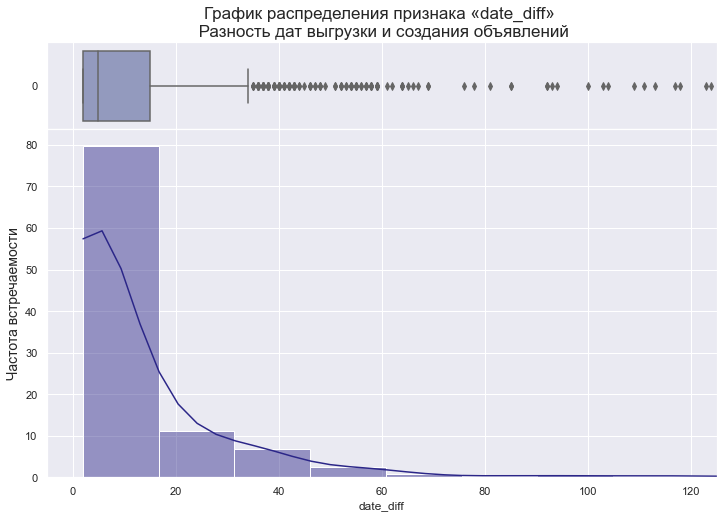

In [18]:
# оценка описательных статистик и распределений признаков даты объявлений
num_feature_research(
    df['date_diff'].loc[df['date_diff'] > 1].reset_index(drop=True),
    'date_diff',
    'Разность дат выгрузки и создания объявлений',
    x_lims=(-5, 125)
)

Медианное значение равно `0`, среднее `0.09`. Это означает, что большинство объявлений выгружено в тот же день, что и было создано (возможно обновлено). Оценим долю тех объявлений, которые были выгружены не менее чем через день после создания.

In [19]:
# определение количества объявлений, выгруженных не менее чем через один день после создания

print('-' * 95)
print('| {: <80}|'.format('Доля объявлений, выгруженных не менее чем через один день после создания:'), end='')
print('{: >10.5f} |'.format(df.loc[df['date_diff'] > 1].shape[0] / df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений, выгруженных не менее чем через один день после создания:       |   0.00426 |
-----------------------------------------------------------------------------------------------


Для подавляющего большинства данных значение разницы между датами выгрузки и создания объявления не превышает одного дня.

Удалим выбросы - оставим для обучения моделей только те объявления, которые были выгружены не позже, чем через 30 дней с момента создания. Оставшиеся объявления могут содержат устревшие ценовые сведения и с точки зрения обучения моделей, предсказывающей цену автомобиля, дальнейшее использование этих объявлений нецелесообразно.

Предварительное оценим количество подобных данных.

In [20]:
# определение количества объявлений, выгруженных через 30 и более дней после создания
print('-' * 95)
print('| {: <80}|'.format('Доля объявлений, выгруженных через 30 и более дней после создания:'), end='')
print('{: >10.5f} |'.format(df.loc[df['date_diff'] > 30].shape[0] / df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений, выгруженных через 30 и более дней после создания:              |   0.00051 |
-----------------------------------------------------------------------------------------------


Доля объявлений, выгруженных через 30 и более дней после создания весьма незначительна и может быть удалена без какого-либо заметного влияния на обучающий набор данных.

In [21]:
# удаление объявлений, выгруженных через 30 и более дней после создания
df = df.loc[~(df['date_diff'] > 30)]

In [22]:
# вывод первых строк таблицы для контроля полученных результатов
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,date_diff
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0


> * Содержащаяся в атрибутах, связанных с датами `date_crawled` и `date_created`, полезная информация использована. Из набора данных удалена незначительная доля объявления, выгруженных через `30` и более дней после создания. Сами атрибуты, связанные с датами, после этого исключены из таблицы.

##### Год регистрации (`registration_year`)

Год регистрации автомобиля соотносится с годом его выпуска, а это один из самых важных факторов, влияющих на стоимость автомобиля. С каждым годом стоимость автомобиля снижается, если только он не относятся к коллекционным или ретро экземплярам.

Признак: «registration_year»


count    354183.000000
mean       2004.235144
std          90.251421
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «registration_year»:                   |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «registration_year»:                         |   0.00000 |
-----------------------------------------------------------------------------------------------



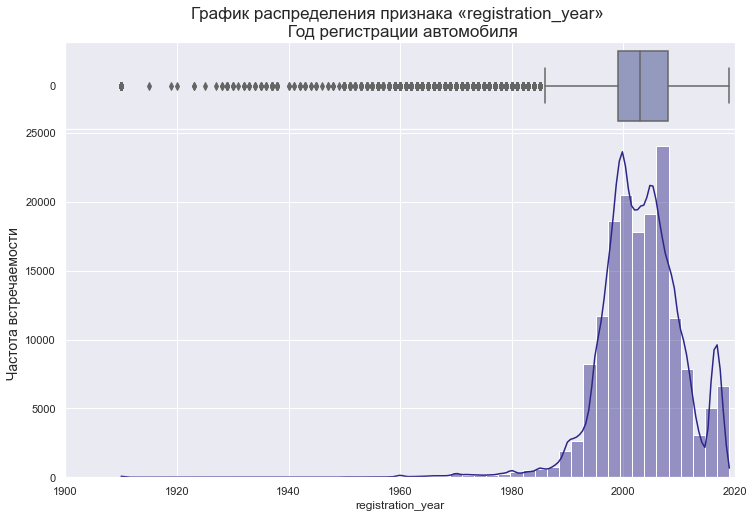

In [23]:
# оценка описательных статистик и распределения признака года регистрации
num_feature_research(
    df.loc[(df['registration_year'] > 1900) & (df['registration_year'] < 2020)]['registration_year'],
    'registration_year',
    'Год регистрации автомобиля',
    x_lims=(1900, 2020)
)

В данных по году регистрации автомобилей присутствуют явные аномалии как слева, так и справа от медианного значения. Примеры:
* минимум `1000` год;
* максимум `9999` год.

Ограничимся корректными временными рамками с `1950` по `2020` год и посмотрим какое количество данных выходит за их границы.

In [24]:
# определение количества объявлений, выходящих за временные рамки 1950-2020 гг.
value = df.loc[(df['registration_year'] < 1950) | (df['registration_year'] > 2020)].shape[0] / df.shape[0]

print('-' * 95)
print('| {: <80}|'.format('Доля объявлений, выходящих за временные рамки 1950-2020 гг.:'), end='')
print('{: >10.5f} |'.format(value))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений, выходящих за временные рамки 1950-2020 гг.:                    |   0.00099 |
-----------------------------------------------------------------------------------------------


Доля объявлений, выходящих за временные рамки 1950-2020 гг. незначительна и может быть удалена без какого-либо заметного влияния на обучающий набор данных.

In [25]:
# удаление объявлений, выходящих за временные рамки 1950-2020 гг. 
df = df.loc[~((df['registration_year'] < 1950) | (df['registration_year'] > 2020))]

Проверим даты регистрации автомобиля относительно даты создания объявлений на предмет наличия аномалий. Для этого создадим новый атрибут - дату регистрации `date_registration`, объединяющий в себе год `registration_year` и месяц `registration_month` регистрации автомобиля.

In [26]:
# функция получения даты регистрации автомобиля
def get_registration_date(row):
    months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
    reg_year = row['registration_year']
    reg_month = row['registration_month']
    if reg_month not in months:
        reg_month = '01'
    return f'{reg_year}-{reg_month}-01'

In [27]:
# создание нового признака в виде даты регистрации автомобиля
df['date_registration'] = df.apply(get_registration_date, axis=1)
df['date_registration'] = pd.to_datetime(df['date_registration'], format='%Y-%m-%d')

Проверим наличие объектов у которых дата регистрации автомобиля больше даты создания объявления, что является явной аномалией, так как фактически означает продажу автомобилей из будущего.

In [28]:
# определение количества объявлений, у которых дата регистрации автомобилей находится позднее даты создания анкеты

value = df.loc[(df['date_registration'] > df['date_created'])].shape[0] / df.shape[0]


print('-' * 95)
print('| {: <80}|'.format('Доля объявлений, у которых дата регистрации превышает дату создания объявления:'), end='')
print('{: >10.5f} |'.format(value))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений, у которых дата регистрации превышает дату создания объявления: |   0.04075 |
-----------------------------------------------------------------------------------------------


Аномальных объектов, у которых дата регистрации автомобиля больше даты создания объявления `4%` от общего количества данных. Возможные причины появления подобных аномалий необходимо уточнить у поставщика данных. На данном этапе просто удалим их.

In [29]:
# удаление аномальных данных с датой регистрации превышающей дату создания объявлений
df = df.loc[~(df['date_registration'] > df['date_created'])]

Также очевидно, что даты размещения/выгрузки объявления не могут являться обучающими признаками для прогнозирования цены так как время размещения объявления не является атрибутом автомобиля. Соответственно, из обучающих признаков можно удалить все временные признаки.

In [30]:
# удаление временных признаков из набора данных
df = df.drop(columns=['date_crawled', 'date_created', 'date_diff', 'date_registration'])

> * Данные по году регистрации автомобиля `registration_year` актуализированы. Для этого были удалены около `0.1%` данных с аномальными значениями признака в виде годов регистрации, выходящих за временные рамки 1950-2020 гг.
> * Обнаружены в количестве около `4%` аномальные значения для признака год регистрации автомобилей `registration_year` около верхней границы данных в виде объектов у которых год и месяц регистрации машины превышают дату создания анкеты. Указанные аномалии удалены.

##### Месяц регистрации (`registration_month`)

Оценим распределение месяца регистрации автомобилей.

Признак: «registration_month»


count    339412.000000
mean          5.758709
std           3.707686
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «registration_month»:                  |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «registration_month»:                        |   0.00000 |
-----------------------------------------------------------------------------------------------



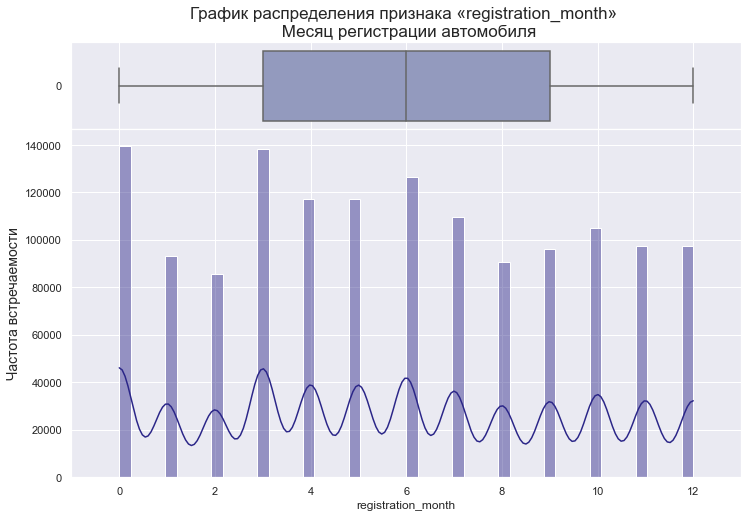

In [31]:
# оценка описательных статистик и распределения признака месяца регистрации
num_feature_research(
    df['registration_month'],
    'registration_month',
    'Месяц регистрации автомобиля',
    x_lims=(-1, 13)
)

Аномальными для месяца регистрации автомобиля являются значения `0`. Проверим какую долю они занимают по отношению ко всем данным.

In [32]:
# определение количества объявлений с месяцом регистрации равным 0

print('-' * 95)
print('| {: <80}|'.format('Доля объявлений с месяцом регистрации равным 0:'), end='')
print('{: >10.5f} |'.format(df.loc[df['registration_month'] == 0].shape[0] / df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений с месяцом регистрации равным 0:                                 |   0.09873 |
-----------------------------------------------------------------------------------------------


Объявлений с 0 в качестве месяца регистрации порядка `10%` от общего числа объявлений. С учётом того, что данные по месяцу регистрации распределены достаточно равномерно, замену значения `0` целесообразно сделать таким образом, чтобы не изменить исходное распределение.

Предлагается сделать замену случайным образом на число из диапазона (1, 12) воспользовавшись методом *randint* библиотеки *numpy*.

In [33]:
# замена объектов со значением 0 в качестве месяца регистрации на случайной число в диапазоне 1-12
np.random.seed(RND)
df.loc[df['registration_month'] == 0, 'registration_month'] = np.random.randint(
    1, 13, df.loc[df['registration_month'] == 0, 'registration_month'].shape[0]
)

> * Данные по месяцу регистрации автомобиля `registration_month` актуализированы. Для аномальных значений в виде нулевого месяца в количестве около `10.0%` от общего количества данные были заполнены случайным образом значениями от 1 до 12.

##### Марка автомобиля (`brand`)

Рассмотрим распределение значений в признаке марка автомобилей `brand`. Марка автомобиля является одним из ключевых признаков, определяющим его стоимость. От марки часто будет зависеть признак `model` - модель, который в свою очередь также неявно определяет прочие характеристики.


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «brand»:                               |         0 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «brand»:                                     |   0.00000 |
-----------------------------------------------------------------------------------------------



volkswagen        0.215461
opel              0.111867
bmw               0.105403
mercedes_benz     0.091275
audi              0.083839
ford              0.071126
renault           0.049860
peugeot           0.031278
fiat              0.026947
seat              0.019242
mazda             0.015892
skoda             0.015783
smart             0.014802
citroen           0.014451
nissan            0.013983
toyota            0.013137
hyundai           0.010153
volvo             0.009240
sonstige_autos    0.009228
mini              0.009101
mitsubishi        0.008571
honda             0.007908
kia               0.006962
suzuki            0.006617
alfa_romeo        0.006573
chevrolet         0.005003
chrysler          0.004095
dacia             0.002575
daihatsu          0.002298
porsche           0.002192
subaru            0.002171
jeep              0.001900
trabant           0.001676
land_rover        0.001582
saab              0.001511
daewoo            0.001511
jaguar            0.001473
r

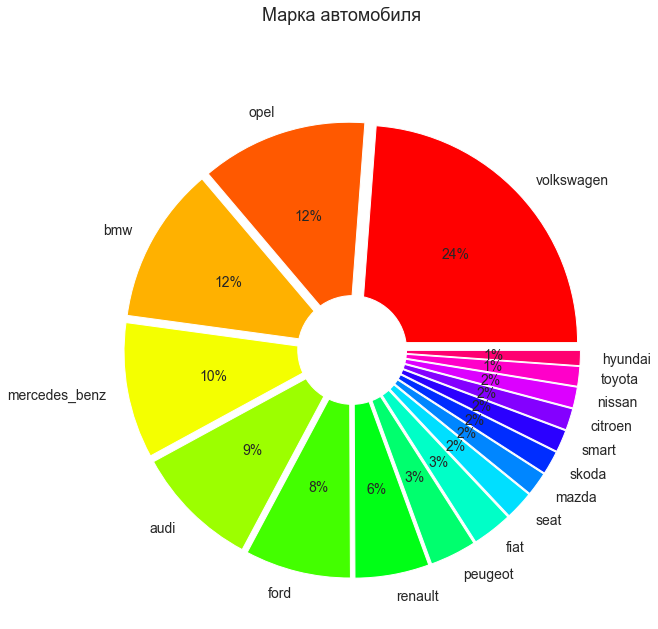

In [34]:
# оценка соотношения значений признака марка автомобиля
cat_feature_research('brand', 'Марка автомобиля', size=(12, 10), cmap='hsv')

Пропущенных значений в признаке марка автомобиля `brand` нет. Но, присутствует значение `sonstige_autos`, которое не является маркой, а скорее соответствует категории `прочие марки автомобилей`. Доля автомобилей без указания марки в общем объеме объявлений немногим менее `1.0%`. Посмотрим на примеры подобных данных.

In [35]:
# просмотр записей без указания марки
df[df['brand'] == 'sonstige_autos'].head(15)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
59,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN
306,200,NaN,2009,NaN,0,NaN,10000,8,NaN,sonstige_autos,NaN
431,3950,small,2004,auto,5,NaN,70000,5,gasoline,sonstige_autos,no
650,15000,coupe,1971,NaN,0,NaN,5000,4,NaN,sonstige_autos,no
661,9900,suv,2000,auto,250,NaN,150000,4,lpg,sonstige_autos,no
700,6999,sedan,2010,auto,186,NaN,125000,4,petrol,sonstige_autos,no
985,500,sedan,2010,manual,101,NaN,70000,1,petrol,sonstige_autos,yes
999,3900,wagon,1990,manual,0,NaN,30000,5,petrol,sonstige_autos,NaN
1098,11500,bus,1985,auto,160,NaN,125000,10,petrol,sonstige_autos,NaN
1106,9200,sedan,2005,auto,249,NaN,150000,10,petrol,sonstige_autos,no


Дополнительно посмотрим какие марки автомобилей присутствуют в данных, в которых не указана марка автомобиля `brand`.

In [36]:
# просмотр марок автомобилей в записях без указания марки
df[df['brand'] == 'sonstige_autos']['model'].value_counts()

Series([], Name: model, dtype: int64)

Все данные, в которых не указана марка автомобиля `brand`, имеют также пропущенные значения по признаку `model`. Так как в этих данных не определены два ключевых признака, определяющих цену, то их целесообразно удалить предварительно оценив их долю.

In [37]:
# определение количества объявлений с аномально низкими значениями цены
print('-' * 95)
print('| {: <80}|'.format('Доля объявлений со значением brand=\'sonstige_autos\':'), end='')
print('{: >10.5f} |'.format(df[df['brand'] == 'sonstige_autos'].shape[0] / df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений со значением brand='sonstige_autos':                            |   0.00923 |
-----------------------------------------------------------------------------------------------


In [38]:
# удаление данных с пропущенными значениями по признаку марки
df = df[~(df['brand'] == 'sonstige_autos')]

Тот факт, что среди представленных объявлений более `65%` занимают курпные немецкие автопроизводители (Volkswagen, Opel, BMW, Mercedes-Benz, Audi) совместно с термином `sonstige_autos` (на немецком языке) свидетельствуют о том, что данные получены с ресурса, ориентированного на немецкий авторынок.

> * Данные по марке автомобиля `brand` обработаны путём удаления объектов со значением `brand='sonstige_autos'`, которое не является маркой, а соответствует категории `прочие марки автомобилей` в количестве около `1%`.

##### Модель (`model`)

Модель автомобиля `model` в сочетании с его маркой `brand` - это ключевые характеристики, влияющие на стоимость. Оценим распределение значений признака модель автомобиля.


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «model»:                               |     14388 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «model»:                                     |   0.04279 |
-----------------------------------------------------------------------------------------------



golf                  0.082069
other                 0.070789
3er                   0.057149
polo                  0.037011
corsa                 0.035488
                        ...   
kalina                0.000018
serie_3               0.000012
rangerover            0.000009
range_rover_evoque    0.000006
serie_1               0.000006
Name: model, Length: 250, dtype: float64

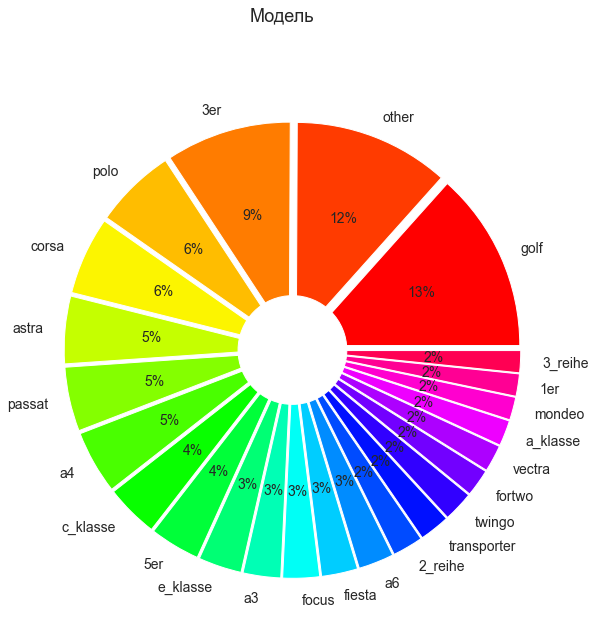

In [39]:
# оценка соотношения значений признака тип коробки передач
cat_feature_research('model', 'Модель', size=(12, 10), cmap='hsv')

Доля пропущенных значений признака `model` составляет около `5%`. Всего модельный ряд представлен списком из `250` различных наименований. Учитывая то, что помимо пропусков в данных присутствует значение `other` (прочие модели, порядка `11%`), целесообразно заменить пропуски указанным значением.

In [40]:
# заполнение пропущенных значений признака модeль
df['model'] = df['model'].fillna('other')

Проверим минимальные значения количества объектов в данных по модели.

In [41]:
# просмотр минимальных значений количества объектов в данных по модели
df['model'].value_counts().sort_values()

serie_1                   2
range_rover_evoque        2
rangerover                3
serie_3                   4
kalina                    6
                      ...  
corsa                 11934
polo                  12446
3er                   19218
golf                  27598
other                 38193
Name: model, Length: 250, dtype: int64

Модель `serie_1` содержит всего один объект. Это бесполезные данные. Если этот объект попадёт в обучающую выборку, то его уже не будет в валидационной и тестовой. И наоборот. Поэтому, удалим все объекты, минимальное значение количества для которых менее `6`.

In [42]:
# удаление объектов, минимальное значение количества для которых меньше 3
min_count_models = list(df['model'].value_counts().sort_values()[:5].index)

df = df.query('model not in @min_count_models')

> * Пропущенные значения по модели автомобиля `model` в количестве `4.6%` обработаны путём заполнения пропущенных значений показателем `other`. Всего модельный ряд представлен списком из `250` различных наименований.

##### Цена (`price`)

Оценим распределение целевого признака - цены автомобиля.

Признак: «price»


count    336263.000000
mean       4463.391577
std        4533.905431
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «price»:                               |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «price»:                                     |   0.00000 |
-----------------------------------------------------------------------------------------------



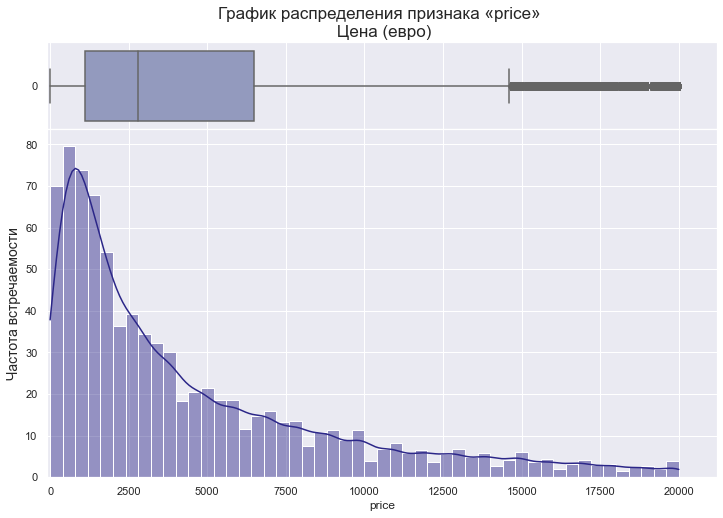

In [43]:
# оценка описательных статистик и распределения признака цены
num_feature_research(
    df['price'], 
    'price', 
    'Цена (евро)', 
    x_lims=(-100, 21200)
)

Распределение цены близко к распределению Пуассона. Аномальными выглядят значения в районе минимальных показателей цены. Рассмотрим их подробнее.

Признак: «price»


count    336263.000000
mean       4463.391577
std        4533.905431
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «price»:                               |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «price»:                                     |   0.00000 |
-----------------------------------------------------------------------------------------------



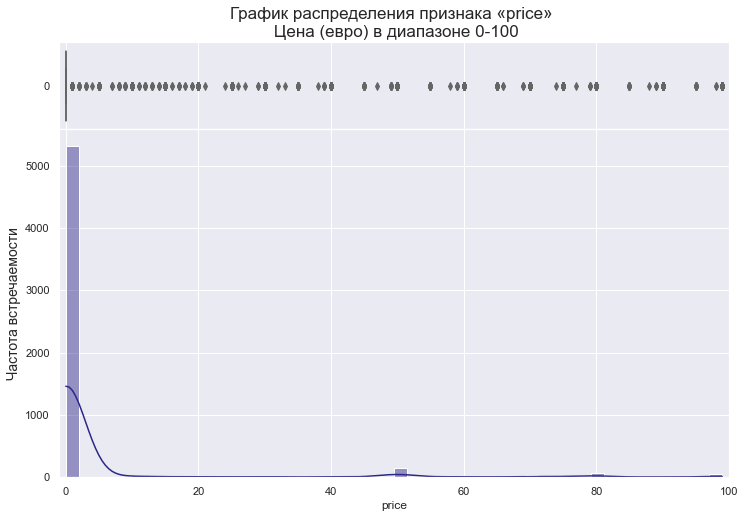

In [44]:
# оценка значений в районе минимальных показателей цены (диапазоне 0-100)
num_feature_research(
    df.loc[df['price'] < 100, 'price'].reset_index(drop=True),
    'price',
    'Цена (евро) в диапазоне 0-100',
    x_lims=(-1, 100)
)

Большинство значений в районе минимальных показателей цены представлены `0`.

Цены менее `100 €` для такого достаточно дорогого товара как автомобили выглядят неправдоподобно и свидетельствуют о высокой доле вероятности ошибки различного рода. Это могут быть объявления из разряда «отдам даром», или «цена по запросу», или при указании цены, предполагалось её измерение в тысячах. В любом случае эти объекты целесообразно исключить из рассмотрения, поскольку цена является целевым признаком.

Перед исключение оценим долю подобных объектов в общем объёме данных.

In [45]:
# определение количества объявлений с аномально низкими значениями цены

print('-' * 95)
print('| {: <80}|'.format('Доля объявлений с аномально низкими значениями цены:'), end='')
print('{: >10.5f} |'.format(df.loc[df['price'] < 100].shape[0] / df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений с аномально низкими значениями цены:                            |   0.03502 |
-----------------------------------------------------------------------------------------------


Объектов с аномально низкими значениями цены `3.6%`. Доля существенная, но так как получить для этих объектов корректные значения не представляется возможным, то произведём их удаление.

In [46]:
# удаление объявлений с аномально низкими значениями цены
df = df.loc[~(df['price'] < 100)]

Также для людей характерно при указании цены либо стремление к круглым числам, оканчивающимся на `0`, к примеру `100`, `550`, `1200`, либо к числам, оканчивающимся на `9`, как способу обозначить цену ниже какого-то психологического барьера, в роли которого как раз часто выступают круглые числа, например `999`, или `4999`. Для небольших значений цен (не измеряемой в тысячах, как в случае с рублями) люди могут также иногда указывать цены, завершающиеся на цифру `5`.

Всё остальное с высокой долей вероятности будет плохо соотвествовать рыночным реалиям, так как человек, указывая подобную цену, скорее всего, не имел серъёзных намерений продажи автомобиля и указал первое попавшееся число. Несколько примеров подобных объектов в выборке.

In [47]:
# примеры объектов с нехарактерными ценами для серъёзно относящегося к продаже человека
(
    df.loc[(df['price'].astype('str').str[-1:] != '0') & 
           (df['price'].astype('str').str[-1:] != '9') & 
           (df['price'].astype('str').str[-1:] != '5')].tail(15)
)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
352808,6666,sedan,2010,manual,111,c5,150000,10,gasoline,citroen,no
352879,2777,wagon,1998,manual,170,5er,150000,12,petrol,bmw,no
352911,1398,small,1998,manual,60,2_reihe,150000,1,petrol,peugeot,no
353067,123,small,2014,manual,75,clio,20000,11,petrol,renault,no
353103,2888,small,2004,manual,60,2_reihe,125000,10,petrol,peugeot,no
353180,666,wagon,2000,auto,150,a6,150000,8,gasoline,audi,yes
353280,844,small,1998,manual,75,lupo,150000,11,lpg,volkswagen,no
353291,1444,sedan,1999,manual,0,156,150000,1,petrol,alfa_romeo,no
353335,7498,suv,2004,manual,0,touareg,150000,4,gasoline,volkswagen,NaN
353490,444,small,1994,manual,45,polo,150000,4,petrol,volkswagen,yes


Оценим долю подобных объявлений по отношению к общему количеству данных.

In [48]:
# определение количества объектов с нехарактерными ценами для адекватно относящегося к продаже автомобиля человека
value = (
    df.loc[(df['price'].astype('str').str[-1:] != '0') & 
           (df['price'].astype('str').str[-1:] != '9') & 
           (df['price'].astype('str').str[-1:] != '5')].shape[0] / df.shape[0]
)

print('-' * 95)
print('| {: <80}|'.format('Доля объявлений с нехарактерными для адекватной продажи ценами:'), end='')
print('{: >10.5f} |'.format(value))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений с нехарактерными для адекватной продажи ценами:                 |   0.01304 |
-----------------------------------------------------------------------------------------------


Объектов с нехарактерными ценами для адекватно относящегося к продаже автомобиля человека около `1.3%`. Произведём их удаление.

In [49]:
# удаление объектов с нехарактерными ценами для адекватно относящегося к продаже автомобиля человека
df = (
    df.loc[~((df['price'].astype('str').str[-1:] != '0') & 
             (df['price'].astype('str').str[-1:] != '9') & 
             (df['price'].astype('str').str[-1:] != '5'))]
)

> * Пропущенных значений в признаке цена `price` не обнаружено. Удалены аномальные значения в признаке цена в количестве около `4.9%` среди которых около `3.6%` составляют объявления с аномально низкими значениями цены и около `1.3%` объявления с нехарактерными для адекватно относящегося к продаже автомобиля человека ценами.

##### Признак выполнения ремонта (`not_repaired`)

Оценим соотношение значений признака выполнения ремонта автомобилей.


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «not_repaired»:                        |     56926 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «not_repaired»:                              |   0.17775 |
-----------------------------------------------------------------------------------------------



no     0.722831
yes    0.099417
Name: not_repaired, dtype: float64

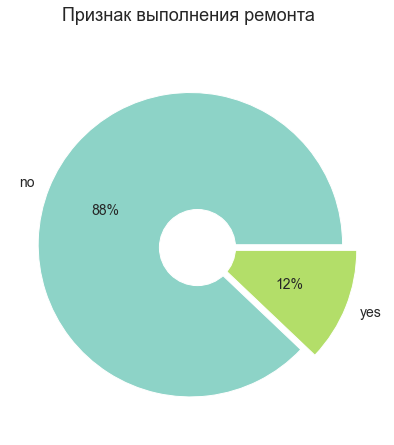

In [50]:
# оценка соотношения значений признака выполнения ремонта
cat_feature_research('not_repaired', 'Признак выполнения ремонта')

Учитывая существенную долю (`17.78%`) объявлений с пропусками в признаке выполнения ремонта и отсутствия дополнительных сведений, из которых указанную информацию можно было бы получить, целесообразно вместо пропусков сделать отдельную категорию - `unknown`. Делать замену на наиболее распространенное значение нецелесообразно, так как ситуация, когда факт проведения ремонта не указан, все-таки отличается от ситуации, когда указано, что автомобиль не ремонтировался.

In [51]:
# заполнение пропущенных значений для признака not_repaired
df['not_repaired'] = df['not_repaired'].fillna('unknown')

> * Данные по признаку выполнения ремонта `not_repaired` содержали около `18.8%` пропущенных значений, которые заполнены отдельно созданной категорией `unknown`.

##### Тип топлива (`fuel_type`)

Оценим распределение значений признака типа топлива.


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «fuel_type»:                           |     22254 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «fuel_type»:                                 |   0.06949 |
-----------------------------------------------------------------------------------------------



petrol      0.622168
gasoline    0.290502
lpg         0.015007
cng         0.001617
hybrid      0.000625
other       0.000393
electric    0.000200
Name: fuel_type, dtype: float64

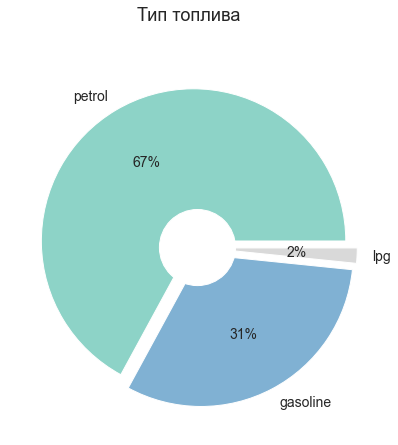

In [52]:
# оценка соотношения значений признака тип топлива
cat_feature_research('fuel_type', 'Тип топлива')

Доля пропущенных значений для признака тип топлива `fuel_type` равна `8.17%`. 

В данных присутствуют автомобили со следующими видами топлива:
* `petrol`, `gasoline` - бензин
* `lpg`, `cng` - разновидности сжиженного газа
* `hybrid` - гибридная силовая установка
* `electric` - электрическая силовая установка.

Немного странно, что полностью отсутствуют автомобили с дизельным типом топлива.

Распределение по виду топлива крайне неравномерно - `98%` приходятся на виды топлива `petrol` и `gasoline`. Учитывая то, что указанные слова являются синонимами бензина, целесообразно заменить эти категории одной `petrol`. Пропущенные значения также заполнить наиболее часто встречающейся категорией `petrol`.

In [53]:
# замена вида топлива с gasoline на petrol
df.loc[df['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

# заполнение пропущенных значений для признака тип топлива
df['fuel_type'] = df['fuel_type'].fillna('petrol')

Две различные категории `lpg` и `cng`, относящиеся к разновидностям сжиженного газа, объединим в одну под общим названием `gas`.

In [54]:
df.loc[df['fuel_type'] == 'lpg', 'fuel_type'] = 'gas'
df.loc[df['fuel_type'] == 'cng', 'fuel_type'] = 'gas'

Посмотрим на автомобили из группы `electric` - с электрической силовой установкой.

In [55]:
# просмотр автомобилей с электрической силовой установкой
df.loc[df['fuel_type'] == 'electric'].head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
6764,15500,small,2014,auto,58,other,30000,4,electric,renault,no
12571,5999,small,2014,auto,15,other,10000,3,electric,renault,no
13227,5799,small,2013,auto,18,other,10000,6,electric,renault,no
13316,4200,coupe,2001,auto,170,c_klasse,125000,8,electric,mercedes_benz,no
20861,170,coupe,1969,NaN,0,kaefer,150000,11,electric,volkswagen,yes
28989,5299,small,2012,auto,11,other,30000,4,electric,renault,no
30569,8300,wagon,2008,auto,140,a4,150000,2,electric,audi,no
33995,4999,small,2012,auto,5,other,5000,10,electric,renault,no
42961,4200,other,2012,auto,8,other,40000,12,electric,renault,no
44601,250,sedan,1998,manual,72,golf,150000,10,electric,volkswagen,unknown


Судя по наименованиям моделей и достаточно старым годам выпуска, автомобили из таблицы выше отнесены к электрическим ошибочно. Поэтому, отнесём их к категории `petrol`. Аналогичную процедуру выполним для категории `other`, которая также немногочисленна.

In [56]:
# замена вида топлива с electric на petrol
df.loc[df['fuel_type'] == 'electric', 'fuel_type'] = 'petrol'

# замена вида топлива с other на petrol
df.loc[df['fuel_type'] == 'other', 'fuel_type'] = 'petrol'

Посмотрим на автомобили из группы `hybrid` - с гибридной силовой установкой.

In [57]:
# просмотр автомобилей с электрической силовой установкой
df.loc[df['fuel_type'] == 'hybrid'].head(20)

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired
1075,5750,sedan,2007,auto,100,other,150000,9,hybrid,toyota,no
4724,4200,sedan,2004,auto,77,other,150000,3,hybrid,toyota,no
5119,5000,sedan,2009,auto,0,other,100000,9,hybrid,honda,no
5307,5200,sedan,2009,auto,0,other,100000,11,hybrid,honda,no
5568,10500,sedan,2011,auto,136,auris,80000,10,hybrid,toyota,no
5693,6500,sedan,2007,auto,95,civic,100000,7,hybrid,honda,unknown
9271,11500,sedan,2011,auto,136,auris,80000,12,hybrid,toyota,no
13156,5500,sedan,2006,auto,95,civic,50000,5,hybrid,honda,no
14098,6500,sedan,2007,auto,110,other,60000,4,hybrid,toyota,no
18572,12000,coupe,2011,manual,114,cr_reihe,60000,9,hybrid,honda,no


Отнесение к группе автомобилей с гибридной силовой установкой, судя по преобладающему наличию японских марок, выглядит корректным. Оставим данную категорию как есть.

> * Данные по признаку тип топлива `fuel_type` содержали около `8.17%` пропущенных значений, которые заполнены наиболее часто встречающейся категорией `petrol`. Значения `gasoline` заменены на `petrol`, так как это одно и то же. Две разновидности газового топлива `lpg` и `cng` объединены в одну с общим названием `gas`. Немногочисленные категории `electric` и `other` после анализа содержащейся в них информации также отнесены к `petrol`.

##### Тип коробки передач (`gearbox`)

Оценим распределение значений признака тип коробки передач.


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «gearbox»:                             |     13880 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «gearbox»:                                   |   0.04334 |
-----------------------------------------------------------------------------------------------



manual    0.766234
auto      0.190426
Name: gearbox, dtype: float64

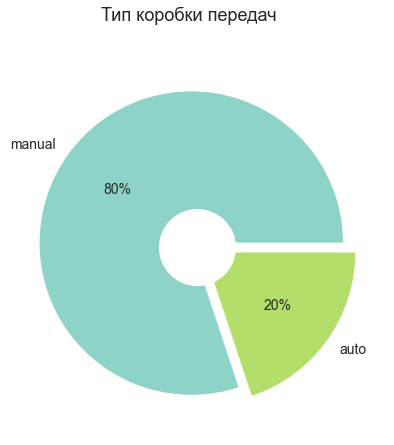

In [58]:
# оценка соотношения значений признака тип коробки передач
cat_feature_research('gearbox', 'Тип коробки передач')

Доля пропущенных значений для признака тип коробки передач `gearbox` составляет `4.33%`.

Соотношение автомобилей с ручной коробкой передач к автомобилям с автоматической равно `4:1`. Учитывая относительно небольшой объём пропусков данных, нецелесообразно выделять отдельную категорию (например, `unknown`) - имеет смысл заменить на наиболее распространенное значение - `manual`.

In [59]:
# заполнение пропущенных значений для признака тип коробки передач
df['gearbox'] = df['gearbox'].fillna('manual')

> * Данные по признаку тип коробки передач `gearbox` содержали около `4.63%` пропущенных значений, которые заполнены наиболее распространённым значением `manual`. Соотношение автомобилей с ручной коробкой передач к автомобилям с автоматической в исследуемых данных равно `4:1`.

##### Пробег (`kilometer`)

Оценим распределение значений пробега.

Признак: «kilometer»


count    320256.000000
mean     128698.728517
std       36878.783566
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «kilometer»:                           |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «kilometer»:                                 |   0.00000 |
-----------------------------------------------------------------------------------------------



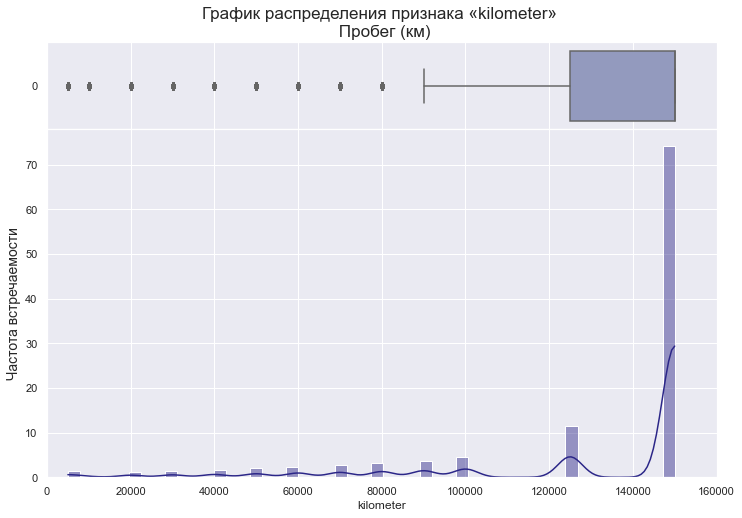

In [60]:
# оценка описательных статистик и распределения признака пробега
num_feature_research(
    df['kilometer'],
    'kilometer', 
    'Пробег (км)', 
    x_lims=(-10, 16e+4)
)

Значения распределены в интервале от `5000` до `150000` с шагом в виде прогрессии `5000`-`10000`-`25000`. Вероятнее всего, на ресурсе, с которого получены указанные объявления, ввод пробега осуществляется путём выбора одного из значений из предопределённого списка (судя по всему, с ограничениями: минимальное значение - от `0` до `5000`, максимальное - свыше `150000`). 

Поэтому, целесообразно значения пробега привести к тыс. км.

In [61]:
# перевод пробега автомобиля в тыс. километров
df['kilometer'] = (df['kilometer'] / 1000).astype('int64')

Оценим полученные уникальные значения.

In [62]:
# распределение уникальных значений пробега автомобилей
df['kilometer'].value_counts()

150    215174
125     33628
100     13493
90      10739
80       9348
70       8021
60       6994
50       5782
40       4605
5        4076
30       3999
20       3456
10        941
Name: kilometer, dtype: int64

В целом можно отметить, что признак пробега можно отнести к категориальным - количество уникальных значений ограничено (судя по всему, на указанном ресурсе выбор пробега осуществляется путём выбора одного из значений из предопределённого списка).

> * Пропущенных значений в признаке пробег `kilometer` не обнаружено. Значения пробега переведены делением на 1000 из единиц измерения в `км.` в `тыс. км.`.
> * Большая часть автомобилей в исследуемых данных характеризуется максимальными значениями пробега, что также может косвенно говорить о принадлежности исследуемых данных к рынку Гремании, которая известна автобанами отличного качества с отсутствем скоростных ограничений.

##### Тип кузова (`vehicle_type`)

Оценим распределение значений признака типа кузова.


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «vehicle_type»:                        |     18221 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «vehicle_type»:                              |   0.05690 |
-----------------------------------------------------------------------------------------------



sedan          0.273213
small          0.237788
wagon          0.195003
bus            0.086603
convertible    0.059771
coupe          0.047090
suv            0.034894
other          0.008743
Name: vehicle_type, dtype: float64

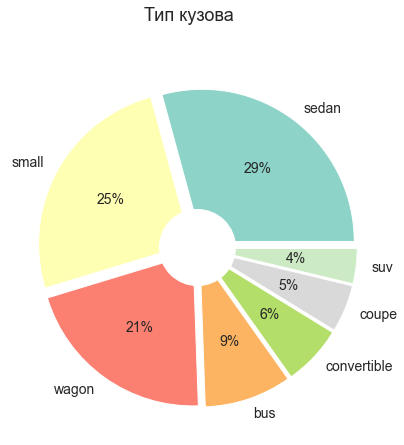

In [63]:
# оценка соотношения значений признака типа коробки передач
cat_feature_research('vehicle_type', 'Тип кузова')

Доля пропущенных значений признака тип кузова `vehicle_type` составляет `5.69%`. Данных с пропусками в типе кузова достаточно много, при этом для многих подобных объявлений указаны марка и модель, что позволит выполнить замену, модельно, обучив подходящий алгоритм машинного обучения на имеющихся данных.

Обучим модель *LGBMClassifier* для заполнения пропущенных значений признака тип кузова `vehicle_type` для задачи мультиклассовой классификации.

Для этого выделим данные для которых извествен признак тип кузова `vehicle_type`. Чтобы не произошло утечки данных (*target leakage*) указанную операцию проведём, исключив признак цены `price`. После обучения, если будет получена модель, демонстрирующая на тестовой выборке результаты выше случайных, сделаем прогноз для подвыборки с пропущенными значениями признака тип кузова `vehicle_type` и заполним пропуски полученными значениями.

In [64]:
# формирование обучающей выборки из всех атрибутов, кроме price и vehicle_type
train_df = df.loc[df['vehicle_type'].notna()].drop(['price', 'vehicle_type'], axis=1)

# выделение целевого признака тип кузова vehicle_type
target = df.loc[df['vehicle_type'].notna(), 'vehicle_type']

In [65]:
# проверка размеров полученных данных
train_df.shape, target.shape

((302035, 9), (302035,))

Перекодируем целевой признак тип кузова `vehicle_type` из текстовых значений в числовые метки типа 0, 1, 2 и т.д., чтобы после обучения модели можно было рассчитать метрику *accuracy*.

In [66]:
# преобразование целевого признака из Series в DataFrame, чтобы можно было применить метод apply()
target = pd.DataFrame(target)

In [67]:
# создание словаря для перекодирования числовыми значениями признака тип кузова 
vehicle_dict = {x[1][0]: x[0] for x in zip(range(0, 8), target.value_counts().index)}

# функция для перекодирования
def veh_class(row):
    return vehicle_dict[row['vehicle_type']]

# перекодирование с использованием метода apply()
target_df = target.apply(veh_class, axis=1)

In [68]:
# просмотр полученного словаря
vehicle_dict

{'sedan': 0,
 'small': 1,
 'wagon': 2,
 'bus': 3,
 'convertible': 4,
 'coupe': 5,
 'suv': 6,
 'other': 7}

Разделим выборку *train_df* на две части: обучающую и тестовую в соотношении 3:1. Обучим модель на тестовой выборке и на тестовой оценим значение метрики на прогнозах модели.

In [69]:
# разделение выборки на обучающую и тестовую
X_train, x_test, y_train, y_test = train_test_split(
     train_df, target_df, test_size=0.25, random_state=RND
)

In [70]:
# проверка размеров полученных выборок
X_train.shape, x_test.shape

((226526, 9), (75509, 9))

In [71]:
# выделение категориальных признаков и изменение типов данных
cat_features = ['model', 'brand', 'fuel_type', 'gearbox', 'not_repaired']

for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    x_test[c] = x_test[c].astype('category')

In [72]:
# создание модели с необходимыми настройками гиперпараметров
model_lgb = LGBMClassifier(
    n_estimators=1500, 
    max_depth=15, 
    learning_rate=0.1, 
    objective='multiclass', 
    n_jobs=-1, 
    random_state=RND,
    reg_lambda=0.0015
)

In [73]:
%%time
# сохраниние результатов обучения модели с использованием pickle для сокращения времени работы ячейки при
# повторном перезапуске
try:
    with open('model_lgb_1.pkl', 'rb') as f:
        model_lgb = pickle.load(f)
except FileNotFoundError:
    # обучение моделей на основе LGBMClassifier
    model_lgb.fit(X_train, y_train, categorical_feature=cat_features, eval_metric='multi_logloss')
    
    with open('model_lgb_1.pkl', 'wb') as f:
        pickle.dump(model_lgb, f)

C:\Users\Oleg\anaconda3\envs\ds\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: total: 3min 35s
Wall time: 18.4 s


In [74]:
# проверка модели по метрике accuracy на тестовой выборке
predicted_classes = model_lgb.predict(x_test)

accuracy = accuracy_score(y_test, predicted_classes.ravel())

print('-' * 95)
print('| {: <80}|'.format('Значение accuracy для модели на тестовых данных:'), end='')
print('{: >10.5f} |'.format(accuracy))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Значение accuracy для модели на тестовых данных:                                |   0.74496 |
-----------------------------------------------------------------------------------------------


Значение метрики *accuracy* для модели составило `0.743`. Сравним полученный результат с аналогичной метрикой случайной модели. Для этого найдём наилучшее значение метрики среди всех рассчитанных на `5000` итерациях случайно сгенерированных значениях (в диапазоне `0-7`) целевого признака.

In [75]:
%%time
# получение значений точности для случайно сгенерированных значений целевого признака
accuracy = []
best_rnd_result = 0

for i in range(5000):
    np.random.seed(i)
    predictions = np.random.randint(8, size=y_test.shape[0])
    rnd_result = accuracy_score(y_test, predictions)
    accuracy.append(rnd_result)
    
    if rnd_result > best_rnd_result:
        best_rnd_result = rnd_result

print('-' * 95)
print('| {: <80}|'.format('Значение accuracy для случайно сгенерированных значений целевого признака:'), end='')
print('{: >10.5f} |'.format(round(best_rnd_result, 5)))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Значение accuracy для случайно сгенерированных значений целевого признака:      |   0.12940 |
-----------------------------------------------------------------------------------------------
CPU times: total: 12.5 s
Wall time: 12.3 s


Визуализируем сгенерированныe значения целевого признака. Если полученные значения действиетльно случайны, то на графиках должна быть отображена симметричная форма Гауссовского распределения.

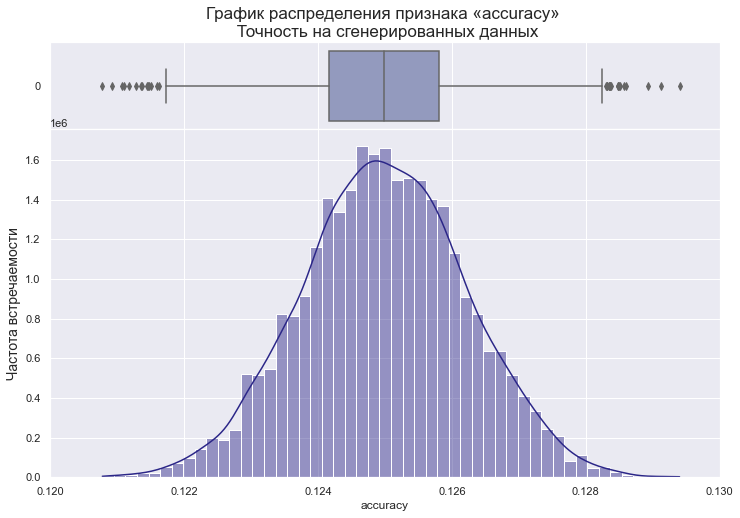

In [76]:
# оценка распределения accuracy для сгенерированных значений целевого признака
num_feature_research(
    pd.DataFrame(accuracy).rename(columns={0:'accuracy'})['accuracy'],
    'accuracy',
    'Точность на сгенерированных данных',
    x_lims=(0.12, 0.13),
    main_df=False
)

Для случайно сгенерированных в `5000` попыток результатов значений целевого признака максимальное значение accuracy составило `0.129`, а для обученной модели `0.743`. Таким образом, обученная модель прогозирует значение целевого признака в виде тип кузова `vehicle_type` значительно точнее, чем его заполнение случайными значениями, и поэтому может быть использовано для заполнения пропущенных значений.

Отберём данные с пропущенными значениями целевого признака в виде тип кузова `vehicle_type`, удалим из них атрибуты `price` и `vehicle_type` после чего получим для них прогнозные значения на обученной ранее модели градиентного бустинга.

In [77]:
# формирование выборки для получения прогнозов целевого признака для заполнения пропущенных значений vehicle_type
features_na = df.loc[df['vehicle_type'].isna()].drop(['price', 'vehicle_type'], axis=1)

In [78]:
# изменение типов данных
for c in cat_features:
    features_na[c] = features_na[c].astype('category')

In [79]:
# получение прогнозов от обученной ранее модели
predicted_classes = model_lgb.predict(features_na)

Произведём обратное преобразование прогнозных значений целевого признака из закодированных числовыми значениями в строковое представление.

In [80]:
# создание словаря для обрадного перекодирования числовыми значениями признака тип кузова 
vehicle_dict_reverse = {x[0]: x[1][0] for x in zip(range(0, 8), target.value_counts().index)}

# функция для обратного перекодирования
def veh_class_reverse(row):
    return vehicle_dict_reverse[row['vehicle_type']]

# обратное перекодирование с использованием метода apply()
vehicle_vals = pd.DataFrame(predicted_classes).rename(columns={0: 'vehicle_type'}).apply(veh_class_reverse, axis=1)


Заполним пропущенные значения атрибута тип кузова `vehicle_type` полученными в результате работы модели значениями.

In [81]:
# заполнение пропущенных значений прогнозами модели градиентного бустинга
df.loc[df['vehicle_type'].isna(), 'vehicle_type'] = vehicle_vals.values

> * Доля пропущенных значений признака тип кузова `vehicle_type` составляла около `5.69%`. Пропущенные значения заполнены по результам прогноза обученной модели на основе *LGBMClassifier*, обученного на всех объектах, которые не содержали пропусков.

##### Мощность (`power`)

Оценим распределение значений мощности автомобилей.

Признак: «power»


count    320256.000000
mean        112.340262
std         185.504052
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «power»:                               |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «power»:                                     |   0.00000 |
-----------------------------------------------------------------------------------------------



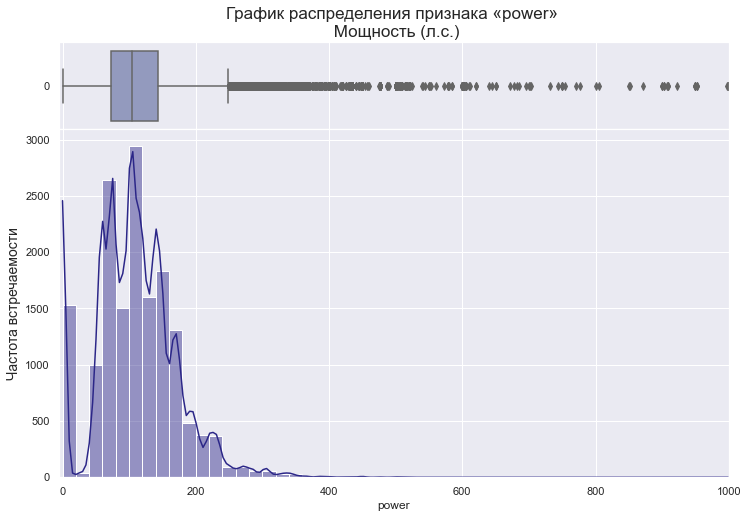

In [82]:
# оценка описательных статистик и распределения признака мощности
num_feature_research(
    df.loc[(df['power'] >= 0) & (df['power'] < 1000)]['power'],
    'power', 
    'Мощность (л.с.)', 
    x_lims=(-5, 1000)
)

В данных по мощности автомобилей присутствуют явные аномалии как слева, так и справа. Слева много нулевых и околонулевых значений мощностей. Справа также наблюдаются значения с аномально высокой мощностью.

Рассмотрим аномалии слева, ограничив данные диапазоном 0-100 л.с.

Признак: «power»


count    320256.000000
mean        112.340262
std         185.504052
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


-----------------------------------------------------------------------------------------------
| Количество пропущенных значений признака «power»:                               |   0.00000 |
-----------------------------------------------------------------------------------------------
| Доля пропущенных значений признака «power»:                                     |   0.00000 |
-----------------------------------------------------------------------------------------------



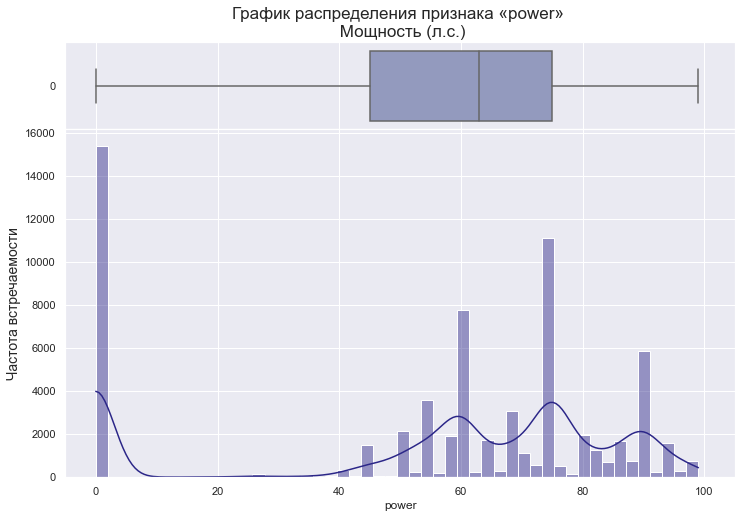

In [83]:
# оценка описательных статистик и распределения признака мощности в диапазоне 0-100 л.с.
num_feature_research(
    df.loc[(df['power'] >= 0) & (df['power'] < 100)]['power'],
    'power', 
    'Мощность (л.с.)', 
    x_lims=(-5, 105)
)

Левую зону выбросов можно разделить на две подзоны:
* нулевые значения - вероятно объявления, в которых значение мощности просто не было указано;
* значения от сверхнизких значений 1 до 25 л.с. (граница 25 л.с. определена в процессе ручного анализа данных).

Оценим долю подобных объявлений по отношению к общему количеству данных.

In [84]:
# определение количества объявлений с аномально низкими значениями мощности

print('-' * 95)
print('| {: <80}|'.format('Доля объявлений с нулевыми значениями мощности:'), end='')
print('{: >10.5f} |'.format(df.loc[df['power'] == 0].shape[0] / df.shape[0]))
print('-' * 95)
print('| {: <80}|'.format('Доля объявлений со сверхнизкими значениями в диапазоне 1-25 л.с.:'), end='')
print('{: >10.5f} |'.format(df.loc[(df['power'] > 0) & (df['power'] < 25)].shape[0] / df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений с нулевыми значениями мощности:                                 |   0.09517 |
-----------------------------------------------------------------------------------------------
| Доля объявлений со сверхнизкими значениями в диапазоне 1-25 л.с.:               |   0.00081 |
-----------------------------------------------------------------------------------------------


Доля объявлений с нулевыми значениями мощности около `10%`. Доля объявлений со сверхнизкими значениями в диапазоне 1-25 л.с. составила около `0.08%`.

Гиперкаров с характерными для них высокими значениями мощности двигателя в данных не обнаружено. В то же время в данных присутсвуют достаточно мощные модели от компании `Porsche` с мощностью двигателя свыше `500` л.с. Поэтому верхней границей мощности можно считать значение в `600` л.с. Оценим долю объектов с аномально высокой мощностью по отношению к общему количеству данных.

In [85]:
# определение количества объявлений с аномально высокими значениями мощности

print('-' * 95)
print('| {: <80}|'.format('Доля объявлений с аномально высокими значениями мощности:'), end='')
print('{: >10.5f} |'.format(df.loc[df['power'] > 600].shape[0] / df.shape[0]))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Доля объявлений с аномально высокими значениями мощности:                       |   0.00098 |
-----------------------------------------------------------------------------------------------


Доля объявлений с аномально высокими значениями мощности составляет около 0.1%.

Нулевые и аномальные значения признака мощность `power` попробуем заменить на основе предсказаний модели, обученной на имеющихся нормальных данных.

Обучим модель на основе *LGBMRegressor* для заполнения нулевых и аномальных значений признака мощность `power`.

Для этого выделим данные для которых извествен признак мощность `power`. Чтобы не произошло утечки данных (*target leakage*) указанную операцию проведём, исключив признак цены `price`. После обучения, если будет получена модель, демонстрирующая на тестовой выборке результаты лучше простого заполнения медианными значениями, сделаем прогноз для подвыборки с пропущенными значениями признака мощность `power` и заполним пропуски полученными значениями.

In [86]:
# формирование обучающей выборки из всех атрибутов, кроме price и power
train_df = (
    df.loc[~((df['power'] == 0) | ((df['power'] > 0) & (df['power'] <= 25)) | (df['power'] > 600))]
    .drop(['price', 'power'], axis=1)
)

# выделение целевого признака тип кузова power
target = df.loc[~((df['power'] == 0) | ((df['power'] > 0) & (df['power'] <= 25)) | (df['power'] > 600)), 'power']

In [87]:
# проверка размеров полученных данных
train_df.shape, target.shape

((289189, 9), (289189,))

Разделим выборку *train_df* на две части: обучающую и тестовую в соотношении 3:1. На тестовой будет проведено обучение модели, а на тестовой получено контрольное значение метрики.

In [88]:
# разделение выборки на обучающую и тестовую
X_train, x_test, y_train, y_test = train_test_split(
     train_df, target, test_size=0.25, random_state=RND
)

In [89]:
# проверка размеров полученных выборок
X_train.shape, x_test.shape

((216891, 9), (72298, 9))

In [90]:
# выделение категориальных признаков и изменение типов данных
cat_features = ['model', 'brand', 'fuel_type', 'gearbox', 'not_repaired', 'vehicle_type']

for c in cat_features:
    X_train[c] = X_train[c].astype('category')
    x_test[c] = x_test[c].astype('category')

In [91]:
# предуставнока основных параметров модели
model_lgb = LGBMRegressor(
    n_estimators=1500,
    max_depth=15,
    n_jobs=-1,
    random_state=RND
)

In [92]:
%%time
# сохраниние результатов обучения модели с использованием pickle для сокращения времени работы ячейки при
# повторном перезапуске
try:
    with open('model_lgb_2.pkl', 'rb') as f:
        model_lgb = pickle.load(f)
except FileNotFoundError:
    # обучение моделей на основе LGBMClassifier
    model_lgb.fit(X_train, y_train, categorical_feature=cat_features)
    
    with open('model_lgb_2.pkl', 'wb') as f:
        pickle.dump(model_lgb, f)

C:\Users\Oleg\anaconda3\envs\ds\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


CPU times: total: 21.5 s
Wall time: 1.88 s


In [93]:
# проверка модели по метрике accuracy на тестовой выборке
predictions = model_lgb.predict(x_test)
predictions = predictions.astype('int64')

rmse = np.sqrt(mean_squared_error(y_test, predictions))

print('-' * 95)
print('| {: <80}|'.format('Значение метрики RMSE для модели на тестовых данных:'), end='')
print('{: >10.5f} |'.format(rmse))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Значение метрики RMSE для модели на тестовых данных:                            |  27.33959 |
-----------------------------------------------------------------------------------------------


Значение метрики *RMSE* для модели составило `27.4`. Чтобы понять хороший это результат или плохой сравним его сначала с простым медианным значением, рассчитанным по `train` выборке, а затем с более продвинутым, рассчитанным в группах по модели `model`.

In [94]:
# определение медианного значения признака мощность power по всем данным
power_median = y_train.median()

# создание массива длины, равной количеству значений в y_test, и заполнение его найденным медианным значением
median_target = []
[median_target.append(power_median) for x in y_test]
median_target = np.array(median_target)

# вычисление RMSE для найденных медианных значений
rmse = np.sqrt(mean_squared_error(y_test, median_target))

print('-' * 95)
print('| {: <80}|'.format('Значение метрики RMSE для медианных значений по всем данным:'), end='')
print('{: >10.5f} |'.format(rmse))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Значение метрики RMSE для медианных значений по всем данным:                    |  54.04605 |
-----------------------------------------------------------------------------------------------


Определим медианные значения в зависимости от атрибута модель `model`. Для этого из `train` выборки создадим вспомогательный датафрейм с группировкой значений мощности `power` в зависимости от модели `model` и определнием медианных значений в полученных группах.

In [95]:
# группировка мощности по моделям и определение медианного значения
power_by_model = (
    pd.concat([X_train, y_train], axis=1)
    .groupby('model')
    .agg({'power': 'median'})
    .rename(columns={'power': 'median_power'})
)

Из полученного датафрейма создадим словарь, который будем использвать для последующего определения медианных значений.

In [96]:
# создание словаря медианных значений мощности в зависимости от модели для функции map()
power_by_model_dict = power_by_model.to_dict()['median_power']

# определение индексов для которых необходимо будет получить медианные значения
indexes = y_train.index

# определение медианных значений  в зависимости от модели с помощью функции map()
median_by_model = df.loc[indexes, 'model'].map(power_by_model_dict).values

In [97]:
# вычисление RMSE для найденных медианных значений

rmse = np.sqrt(mean_squared_error(y_train, median_by_model))

print('-' * 95)
print('| {: <80}|'.format('Значение метрики RMSE для медианных значений по группам марок:'), end='')
print('{: >10.5f} |'.format(rmse))
print('-' * 95)

-----------------------------------------------------------------------------------------------
| Значение метрики RMSE для медианных значений по группам марок:                  |  36.07163 |
-----------------------------------------------------------------------------------------------


Результаты сравнения показывают, что значение метрики *RMSE* обученной модели, равное `≈28.0`, лучше простого заполнения медианными значениями, для которого *RMSE* составило `≈54.0`, а также более продвинутого, рассчитанного для одинаковых по модели `model` групп, для которого *RMSE* составило `≈36.0`.

Используем полученную модель, чтобы заменить нулевые и аномальные значения признака мощность `power` на более корректные.

Отберём данные с пропущенными значениями целевого признака в виде мощности `power`, удалим из них атрибуты `price` и `power` после чего получим для них прогнозные значения на обученной ранее модели градиентного бустинга.

In [98]:
# формирование выборки для получения прогнозов целевого признака для заполнения пропущенных значений vehicle_type
features_na = (
    df.loc[((df['power'] == 0) | ((df['power'] > 0) & (df['power'] <= 25)) | (df['power'] > 600))]
    .drop(['price', 'power'], axis=1)
)

In [99]:
# изменение типов данных
for c in cat_features:
    features_na[c] = features_na[c].astype('category')

# получение прогнозов от обученной ранее модели
predictions = model_lgb.predict(features_na)
predictions = predictions.astype('int64')

In [100]:
# определение индексов аномальных, нулевых и околонулевых значений, которые подлежат замене
indexes = df.loc[((df['power'] == 0) | ((df['power'] > 0) & (df['power'] <= 25)) | (df['power'] > 600))].index

# замена значений на прогнозные по индексам
df.loc[indexes, 'power'] = predictions

> * Пропущенных значений для признака мощности `power` не обнаружено. При этом присуствовали более `10%` объявлений с аномальными, нулевыми и околонулевыми значениями мощности, которые заменены на результы прогноза обученной модели на основе *CatBoostRegressor*, обученной на всех объектах, которые по атрибуту мощность `power` были отнесены к нормальным.

#### Оценка результатов предобработки данных

Посмотрим на сводную информацию о данных после проведения предобработки.

In [101]:
# просмотр сводной информации о данных после предобработки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320256 entries, 0 to 354364
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               320256 non-null  int64 
 1   vehicle_type        320256 non-null  object
 2   registration_year   320256 non-null  int64 
 3   gearbox             320256 non-null  object
 4   power               320256 non-null  int64 
 5   model               320256 non-null  object
 6   kilometer           320256 non-null  int64 
 7   registration_month  320256 non-null  int64 
 8   fuel_type           320256 non-null  object
 9   brand               320256 non-null  object
 10  not_repaired        320256 non-null  object
dtypes: int64(5), object(6)
memory usage: 37.4+ MB


> * После преобработки данных в таблице осталось `333604` объекта из начальных `354365` и `11` атрибутов из начальных `16`. Из оставшихся `11` атрибутов `6` однозначно относятся к категориальным. Это:
>     * `vehicle_type` — тип автомобильного кузова
>     * `gearbox` — тип коробки передач
>     * `model` — модель автомобиля
>     * `fuel_type` — тип топлива
>     * `brand` — марка автомобиля
>     * `not_repaired` — была машина в ремонте или нет
>
> * К количественным можно определённо отнести `3` атрибута:
>     * `price` —  цена (евро), которая является целевым признаком
>     * `registration_year` — год регистрации автомобиля
>     * `power` — мощность (л. с.)
>
> * И `2` атрибута из-за дискретности значений и ограниченного их количества можно отнести как к количественным, так и к категориальным:
>     * `kilometer` —  пробег (тыс.км.)
>     * `registration_month` — месяц регистрации автомобиля

#### Выводы по этапу подготовки данных

> * Данные успешно загружены из файла. Таблица содержит около `350` тыс. записей из объявлений о продаже автомобилей. Данные соотвествуют описанию. В данных обнаружено незначительное количество дубликатов и многочисленные пропуски в различных атрибутах, значение которых для отдельных признаков доходит до `20%` (атрибут `NotRepaired`).
>
> * Названия атрибутов (столбцов) преобразованы `CamelCase` стиля в `snake_case`.
>
> * Из данных удалены признаки, не влияющие на стоимость, такие как количество изображений, почтовый код и время последней активности пользователя.
>
> *  Проведена оценка распределения значений признаков с целью выявления пропусков/аномалий в данных, которые целесообразно заполнить или заменить.
>
> * По результатам оценки признаков, относящихся к самим объявлениям (дата создания `date_crawled`, дата выгрузки `date_created`), исключены аномалии - объявления с большим периодом экспозиции, которые вероятно содержат недостоверные ценовые характеристики.
>
> * По результатам оценки распределения года регистрации автомобилей `registration_year` исключены аномальные значения, выходящих за временные рамки 1950-2020 гг. Аномальные значения по месяцу регистрации автомобиля `registration_month` в виде нулевых показателей заполнены случайными значениями от `1` до `12`.
>
> * Также обнаружены в количестве около `4%` аномальные значения для признака год регистрации автомобилей `registration_year` около верхней границы данных в виде объектов у которых год и месяц регистрации машины превышают дату создания анкеты. Указанные аномалии были удалены.
>
> * Ключевой признак, определяющий стоимость автомобиля - его марка `brand` обработан путём удаления объектов со значением *sonstige_autos*. Для другого ключевого признака - модели автомобиля пропущенные значения заполнены показателем `other`.
>
> * Целевой признак - цена `price` не содержал пропусков. Объекты с аномальными и некорректными значениями цены были удалены. 
>
> * Пропущенные значения в признаке выполнения ремонта `not_repaired` заполнены отдельно созданной категорией `unknown`.
>
> * Пропущенные значения в признаке тип топлива `fuel_type` заполнены наиболее часто встречающейся категорией `petrol`. Значения `gasoline` заменены на `petrol`, так как это одно и то же. Две разновидности газового топлива `lpg` и `cng` объединены в одну с общим названием `gas`. Немногочисленные категории `electric` и `other` после анализа содержащейся в них информации также отнесены к `petrol`.
>
> * Обнаруженные пропущенные значения в признаке тип коробки передач `gearbox` также заменены на на наиболее распространенное в этих данных значение - `manual`.
>
> * Пропущенных значений в признаке пробег `kilometer` не обнаружено. Значения пробега переведены делением на 1000 из единиц измерения в `км.` в `тыс. км.`. Большая часть автомобилей в исследуемых данных характеризуется максимальными значениями пробега.
>
> * Пропуски для признака тип кузова `vehicle_type` заполнены модельными прогнозами обученной модели на основе *LGBMClassifier*.
>
> * В данных по мощности автомобиля пропусков не обнаружены, но зафиксировано наличие нулевых, околонулевых и аномальных значений, которые заменены на прогнозы модели на основе *LGBMRegressor*, обученной на всех объектах, которые по атрибуту мощность `power` были отнесены к нормальным.
>
> * После преобработки данных в таблице осталось `320268` объектов из начальных `354365` и `11` атрибутов из начальных `16`. Из оставшихся `11` атрибутов `6` однозначно относятся к категориальным, `3` (включая целевой признак цену `price`) к количественным и `2` из-за дискретности значений и ограниченного их количества могут быть отнесены как к количественным, так и к категориальным.

## Обучение моделей

Обучение моделей проведём на основе Dummy-модели, которая будет выступать в роли baseline, линейной регрессии, случайного леса, градиентного бустинга CatBoost и LGBM. После обучения проведём сравнительный анализ полученных метрик качества.

Перед обучением необходимо выделить наборы обучающих и целевого признаков, отмасштабировать числовые признаки и подготовить для обучения моделей категориальные.

### Разделение данных на обучающую и тестовую выборки

Разделим признаки на количественные и категориальные группы, а также выделим целевую переменную.

In [102]:
# выделение списка обучающих признаков
features = ['vehicle_type',
            'registration_year',
            'gearbox',
            'power',
            'model',
            'kilometer',
            'registration_month',
            'fuel_type',
            'brand',
            'not_repaired']

# выделение категориальной группы признаков
features_category = ['vehicle_type', 'gearbox', 'model', 'kilometer', 
                     'registration_month', 'fuel_type', 'brand', 'not_repaired']

# выделение группы количественных признаков
features_scale = ['registration_year', 'power']

# выделение целевой переменной
target = ['price']

Разобъём данные на две части - обучающую и тестовую в соотношении 3:1.

In [103]:
# Разделение выборки на обучающую и тестовую в соотношении 3:1.
df_train, df_test = train_test_split(df, test_size=0.25, random_state=RND, stratify=df['brand'])

Проверка размеров полученных частей.

In [104]:
# проверка размеров обучающей, валидационной и тестовой частей
df_train.shape[0], df_test.shape[0]

(240192, 80064)

Разделим полученные выборки на обучающие признаки и целевой признак.

In [105]:
# разделение выборок на обучающие признаки и целевой признак
X_train = df_train[features]
y_train = df_train[target]

x_test = df_test[features]
y_test = df_test[target]

Зададим функцию расчета метрики *RMSE*.

In [106]:
# функция расчета метрики RMSE
def rmse(y_true, y_predicted):
    return mean_squared_error(y_true, y_predicted, squared=False)  

In [107]:
# мера, используемая при кросс-валидации - RMSE
scoring = make_scorer(rmse, greater_is_better=False)

Определим функции вывода значений метрики по результатам обучения и проверки моделей на тестовой выборке.

In [108]:
# функция для печати лучшего значения метрики RMSE на обучении и сводной информации о параметрах модели
def print_scores(grid_search, params, model_name, ret=False):
    """
    input:        grid_search (sklearn.model) - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  model_name (str)            - название используемой модели
    output: grid_search.best_estimator_       - лучшая модель
    description:  Функция выводит на печать значений RMSE и параметры лучшей модели по результатам подобора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    print('-' * 75)
    print('| {: <60}|'.format('Лучшее значение RMSE для модели ' + model_name + ':'), end='')
    print('{: >10.2f} |'.format(np.abs(grid_search.best_score_)))
    print('-' * 75)
        
    print ('| {: <60}|'.format('Лучшие параметры:'), end='')
    print(' ' * 11 + '|')
        
    best_parameters = grid_search.best_estimator_.get_params()
        
    for param_name in sorted(params.keys()):
        print('|\t{: <54}|'.format(param_name), end='')
        print('{: >10} |'.format(str(best_parameters[param_name])))
    print('-' * 75)
            
    if ret == True:
        return grid_search.best_estimator_
    else:
        return None

In [109]:
# функция для печати значения метрики RMSE на тестовых данных
def print_scores_on_test(grid_search, params, x_test, y_test, model_name):
    """
    input:        grid_search (sklearn.model) - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  x_test (pandas.DataFrame)   - тестовый набор данных
                  y_test (pandas.DataFrame)   - таргеты из тестового набора данных
                  model_name (str)            - название используемой модели
    output:       test_score (float)          - значение метрики RMSE на тестовых данных
    description:  Функция выводит на печать значений RMSE и параметры лучшей модели по результатам подобора 
                  гиперпараметров с помощью метода GridSearchCV на обучающих данных
    """
    print('-' * 75)
    print ('| {: <60}|'.format('Параметры модели:'), end='')
    print(' ' * 11 + '|')
    
    best_parameters = grid_search.best_estimator_.get_params()
    
    for param_name in sorted(params.keys()):
        print('|\t{: <54}|'.format(param_name), end='')
        print('{: >10} |'.format(str(best_parameters[param_name])))
        
    test_score = np.abs(grid_search.score(x_test, y_test))
    
    print('-' * 75)
    print('| {: <60}|'.format('RMSE на тестовых данных для ' + model_name + ':'), end='')
    print('{: >10.2f} |'.format(test_score))
    print('-' * 75)
    
    return test_score

In [110]:
# функция получения сравнительных результатов от модели
def get_compare_data(model, grid_search, params, X_train, y_train, model_name):
    """
    input:        model (sklearn.model)       - модель для которой будет определены результаты
                  grid_search (sklearn.model) - лучшая модель по результатам работы GridSearchCV
                  params (dict)               - лучшие параметры
                  X_train (pandas.DataFrame)  - обучающий набор данных
                  y_train (pandas.DataFrame)  - таргеты из обучающего набора данных
                  model_name (str)            - название используемой модели
    output:       test_score (float)          - значение метрики RMSE на тестовых данных
    description:  Функция возвращает значение RMSE для модели на обучении после подбора гиперпараметров,
                  а также время обучения и предсказания
    """
    best_parameters = grid_search.best_estimator_.get_params()
    
    params_dict = {}
    for param_name in sorted(params.keys()):
        params_dict[param_name] = best_parameters[param_name]
    
    
    #pipe.set_params(**params_dict)
    if 'CatBoost' in model_name:
        pipe = CatBoostRegressor()
        pipe.set_params(**best_parameters)
    else:
        pipe = Pipeline(transform_steps + [('model', model)])
        pipe.set_params(**best_parameters)
    
    # обучение модели на лучших гиперпараметрах
    start_time = datetime.datetime.now()
    pipe.fit(X_train, y_train)
    fit_time = (datetime.datetime.now()-start_time).seconds
    
    # получение предсказаний
    start_time = datetime.datetime.now()
    predicted = pipe.predict(X_train)
    predit_time = (datetime.datetime.now()-start_time).seconds
    
    # вычисление метрики
    rmse_score_with_cv = np.abs(grid_search.best_score_)
    rmse_score_without_cv = mean_squared_error(y_train, predicted, squared=False)

    
    print()
    print('-' * 75)
    print('| {: ^71} |'.format('Сравнительные результаты для ' + model_name.upper() + ':'))
    print('-' * 75)
    
    print('| {: <60}|'.format('Время обучения:'), end='')
    print('{: >10d} |'.format(fit_time))
    print('-' * 75)
    
    print ('| {: <60}|'.format('Время для формирования прогнозов:'), end='')
    print('{: >10d} |'.format(predit_time))
    print('-' * 75)
    
    print ('| {: <60}|'.format('RMSE на обучающих данных с кросс-валидацией:'), end='')
    print('{: >10.2f} |'.format(rmse_score_with_cv))
    print('-' * 75)
    
    print ('| {: <60}|'.format('RMSE на обучающих данных без кросс-валидации:'), end='')
    print('{: >10.2f} |'.format(rmse_score_without_cv))
    print('-' * 75)
    
    return fit_time, predit_time, rmse_score_with_cv

> * Из данных выделены группы категориальных и количественных признаков, а также целевая переменная.
> * Из предобработанного датасета созданы обучающая и тестовая выборки, разделённые в соотношении 3:1. После этого произведено разделение полученных выборок на содержащие обучающие признаки и на отдельные с целевым признаком.
> * Создана функция расчёта оптимизируемой метрики *RMSE* и на ёё основе создана мера, используемая при кросс-валидации.
> * Для удобства интерпретации результатов обучения моделей и значений метрики *RMSE* созданы вспомогательные функции для вывода сводной информации о модели на этапе обучения и значения метрики *RMSE* на тестовых данных.

### Dummy-модель

Для последующей оценки полученных результатов проверки моделей на тестовых данных рассмотрим несколько dummy-моделей, выполняющих «предсказания» по одному из простых принципов:
- медианное значение цены
- среднее значение по бренду
- среднее значение по модели

In [111]:
# вычисление RMSE метрики для dummy-модели на основе медианных значений цены
dummy = DummyRegressor(strategy='median')
dummy.fit(X_train, y_train)

model_dm_1 = rmse(y_test.values.ravel(), dummy.predict(x_test)) 

print('-' * 75)
print('| {: <60}|'.format('Значение метрики RMSE для dummy модели на тестовых данных:'), end='')
print('{: >10.2f} |'.format(model_dm_1))
print('-' * 75)

---------------------------------------------------------------------------
| Значение метрики RMSE для dummy модели на тестовых данных:  |   4804.40 |
---------------------------------------------------------------------------


Значение метрики первой dummy-модели равно `≈4804` евро (т.е. замена на медиану позволяет определить цену автомобиля в среднем с ошибкой `±4804` евро).

In [112]:
# вычисление RMSE метрики для dummy-модели на основе средних значений цены по бренду
df_brand_mean_price =  (
    df_train.groupby('brand').agg({'price': 'mean'}).rename(columns={'price': 'mean_price'}).reset_index()
)

predictions = df_test.merge(
    df_brand_mean_price, left_on='brand', right_on ='brand', how='inner'
)['mean_price']


model_dm_2 = rmse(y_test.values.ravel(), predictions)

print('-' * 75)
print('| {: <60}|'.format('Значение метрики RMSE для dummy модели на тестовых данных:'), end='')
print('{: >10.2f} |'.format(model_dm_2))
print('-' * 75)

---------------------------------------------------------------------------
| Значение метрики RMSE для dummy модели на тестовых данных:  |   4759.07 |
---------------------------------------------------------------------------


Значение метрики второй dummy-модели, рассчитанной по средним значениями по бренду, равно `≈4763` евро.

In [113]:
# вычисление RMSE метрики для dummy-модели на основе средних значений цены по модели
df_model_mean_price = (
    df_train.groupby('model').agg({'price': 'mean'}).rename(columns={'price': 'mean_price'}).reset_index()
)

predictions = df_test.merge(
    df_model_mean_price, left_on='model', right_on ='model', how='inner'
)['mean_price']


model_dm_3 = rmse(y_test.values.ravel(), predictions)

print('-' * 75)
print('| {: <60}|'.format('Значение метрики RMSE для dummy модели на тестовых данных:'), end='')
print('{: >10.2f} |'.format(model_dm_3))
print('-' * 75)

---------------------------------------------------------------------------
| Значение метрики RMSE для dummy модели на тестовых данных:  |   5116.82 |
---------------------------------------------------------------------------


Значение метрики третьей dummy-модели, рассчитанной по средним значениями по марке, равно `≈5123` евро.

> * В качестве базового значения ошибки при сравнении моделей будем использовать наименьшее из найденных значений для dummy-моделей, равное `≈4763` евро.

### Линейная регрессия

В качестве шагов преобразования данных определим масштабирование и кодирование с помощью OrdinalEncoder (целочисленный код категории). Указанный способ кодирования категориальных признаков ближе к применяемым в CatBoost численным способам кодирования.

In [114]:
# pipline для препроцессинга обучающих данных
transform_steps = [
    (
        'qtl', ColumnTransformer(
            remainder='passthrough',
            transformers=[
                ('std', StandardScaler(copy=False, with_mean=True, with_std=True), features_scale),
                ('cat', OrdinalEncoder(), features_category)
            ])
    ),
]

In [115]:
# создание модели на основе линейной регрессии с заданным набором параметров
model_lr = LinearRegression(n_jobs=-1)

# создание списка гиперпараметров для перебора
params = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

In [116]:
# создание перебора гиперапараметров для обучаемой модели
grid_search = GridSearchCV(
        Pipeline(transform_steps + [('model', model_lr)]), 
        param_grid=params, 
        cv=CV_FOLDS, 
        scoring=scoring,
    ) 

In [117]:
%%time
start_time = datetime.datetime.now()
# обучение модели линейной регрессии и получени лучшего результата на обучении
grid_search.fit(X_train, y_train.values.ravel())

learning_time_lr = (datetime.datetime.now()-start_time).seconds

print_scores(grid_search, params, 'линейной регрессии')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели линейной регрессии:         |   3044.43 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__fit_intercept                                  |      True |
|	model__positive                                       |     False |
---------------------------------------------------------------------------
CPU times: total: 45.2 s
Wall time: 10.2 s


In [118]:
# получение сравнительных результатов для линейной регрессии
fit_time_lr, pred_time_lr, rmse_score_lr = get_compare_data(
    model_lr, grid_search, params, X_train, y_train, 'линейной регрессии'
)


---------------------------------------------------------------------------
|            Сравнительные результаты для ЛИНЕЙНОЙ РЕГРЕССИИ:             |
---------------------------------------------------------------------------
| Время обучения:                                             |         0 |
---------------------------------------------------------------------------
| Время для формирования прогнозов:                           |         0 |
---------------------------------------------------------------------------
| RMSE на обучающих данных с кросс-валидацией:                |   3044.43 |
---------------------------------------------------------------------------
| RMSE на обучающих данных без кросс-валидации:               |   3044.30 |
---------------------------------------------------------------------------


> * С помощью линейной регрессии удалось достичь значения метрики *RMSE* `≈3044`, что в 1.5 раза лучше, чем аналогичная метрика dummy-модели.

### Случайный лес

Рассмотрим модель случайного леса. В качестве диапазона перебираемых гиперпараметров укажем глубину дерева и количество деревьев.

In [119]:
# создание модели на основе случайной регрессии с заданным набором параметров
model_rf = RandomForestRegressor(random_state=RND, n_jobs=-1)

params = {
    'model__n_estimators': [200],
    'model__max_depth': [19],
}

In [120]:
# создание перебора гиперапараметров для обучаемой модели
grid_search = GridSearchCV(
        Pipeline(transform_steps + [('model', model_rf)]), 
        param_grid=params, 
        cv=CV_FOLDS, 
        scoring=scoring,
    )

In [121]:
%%time
# сохраниние результатов подбора гиперпараметров с использованием pickle для сокращения времени работы ячейки при
# повторном перезапуске
try:
    with open('grid_search_rf.pkl', 'rb') as f:
        grid_search = pickle.load(f)
except FileNotFoundError:
    start_time = datetime.datetime.now()
    # обучение моделей на основе случайного леса и получени лучшего результата на обучении
    grid_search.fit(X_train, y_train.values.ravel())
    
    learning_time_rf = (datetime.datetime.now()-start_time).seconds
    
    with open('grid_search_rf.pkl', 'wb') as f:
        pickle.dump(grid_search, f)


print_scores(grid_search, params, 'случайного леса')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели случайного леса:            |   1582.18 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__max_depth                                      |        19 |
|	model__n_estimators                                   |       200 |
---------------------------------------------------------------------------
CPU times: total: 2min 26s
Wall time: 1min 29s


In [122]:
# получение сравнительных результатов для линейной регрессии
fit_time_rf, pred_time_rf, rmse_score_rf = get_compare_data(
    model_rf, grid_search, params, X_train, y_train.values.ravel(), 'случайного леса'
)


---------------------------------------------------------------------------
|              Сравнительные результаты для СЛУЧАЙНОГО ЛЕСА:              |
---------------------------------------------------------------------------
| Время обучения:                                             |        10 |
---------------------------------------------------------------------------
| Время для формирования прогнозов:                           |         1 |
---------------------------------------------------------------------------
| RMSE на обучающих данных с кросс-валидацией:                |   1582.18 |
---------------------------------------------------------------------------
| RMSE на обучающих данных без кросс-валидации:               |    917.38 |
---------------------------------------------------------------------------


> * Модель случайного леса позволила получить значения метрики *RMSE* `≈1582`, что практически в 2.0 раза лучше показателя модели линейной регрессии.

### CatBoost

Обучим модель градиентного бустинга на основе *CatBoostRegressor*. В качестве метрики также используем *RMSE*.

In [123]:
# подготовка обучающего набора данных c помощью конструктора Pool
train_dataset = Pool(data=df_train[features],
                     label=df_train[target],
                     cat_features=features_category)

In [124]:
# предуставнока основных параметров модели
model_cb = CatBoostRegressor(
    iterations=500,
    eval_metric='RMSE',
    cat_features=features_category,
    task_type='CPU',
    thread_count=-1,
    verbose=250,
    random_state=RND
)

In [125]:
# создание списка гиперпараметров для перебора
params = {
    'depth': [14, 15],
    'learning_rate': [0.05, 0.1],
    
}

In [126]:
# создание перебора гиперапараметров для обучаемой модели
grid_search = GridSearchCV(
    estimator=model_cb,
    param_grid=params, 
    cv=CV_FOLDS, 
    scoring=scoring
) 

Так как процесс подобора гиперпараметров занимает продолжительное время, сохраним его результат с использованием pickle и при повторных перезапусках скрипта будем получать результаты из сохранённых данных.

In [127]:
%%time
# сохраниние результатов подбора гиперпараметров с использованием pickle для сокращения времени работы ячейки при
# повторном перезапуске
try:
    with open('grid_search_cb.pkl', 'rb') as f:
        grid_search = pickle.load(f)
except FileNotFoundError:
    start_time = datetime.datetime.now()
    # обучение моделей на основе CatBoostRegressor
    grid_search.fit(X_train, y_train.values.ravel())
    
    learning_time_cb = (datetime.datetime.now()-start_time).seconds
    
    with open('grid_search_cb.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

0:	learn: 4368.5422514	total: 571ms	remaining: 4m 44s
250:	learn: 1426.7954219	total: 1m 37s	remaining: 1m 36s
499:	learn: 1280.9746315	total: 3m 19s	remaining: 0us
0:	learn: 4366.1203464	total: 401ms	remaining: 3m 20s
250:	learn: 1432.0456530	total: 1m 38s	remaining: 1m 37s
499:	learn: 1290.5038996	total: 3m 22s	remaining: 0us
0:	learn: 4369.8769250	total: 372ms	remaining: 3m 5s
250:	learn: 1428.8683399	total: 1m 38s	remaining: 1m 37s
499:	learn: 1283.5696460	total: 3m 23s	remaining: 0us
0:	learn: 4376.7159897	total: 405ms	remaining: 3m 21s
250:	learn: 1422.0887163	total: 1m 39s	remaining: 1m 38s
499:	learn: 1272.9816602	total: 3m 23s	remaining: 0us
0:	learn: 4366.2575681	total: 379ms	remaining: 3m 9s
250:	learn: 1425.9119742	total: 1m 39s	remaining: 1m 38s
499:	learn: 1269.4231443	total: 3m 23s	remaining: 0us
0:	learn: 4365.7040499	total: 369ms	remaining: 3m 4s
250:	learn: 1419.3566801	total: 1m 38s	remaining: 1m 38s
499:	learn: 1280.6554795	total: 3m 24s	remaining: 0us
0:	learn: 436

In [128]:
# отображение лучшего результата на обучении CatBoostRegressor
print_scores(grid_search, params, 'CatBoostRegressor')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели CatBoostRegressor:          |   1542.96 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	depth                                                 |        15 |
|	learning_rate                                         |       0.1 |
---------------------------------------------------------------------------


In [129]:
# получение сравнительных результатов для CatBoostRegressor
fit_time_cb, pred_time_cb, rmse_score_cb = get_compare_data(
    model_cb, grid_search, params, X_train, y_train.values.ravel(), 'градиентного бустинга CatBoost'
)

0:	learn: 4195.2994083	total: 714ms	remaining: 5m 56s
250:	learn: 1234.4819587	total: 3m	remaining: 2m 58s
499:	learn: 1062.9232459	total: 6m 19s	remaining: 0us

---------------------------------------------------------------------------
|      Сравнительные результаты для ГРАДИЕНТНОГО БУСТИНГА CATBOOST:       |
---------------------------------------------------------------------------
| Время обучения:                                             |       382 |
---------------------------------------------------------------------------
| Время для формирования прогнозов:                           |         0 |
---------------------------------------------------------------------------
| RMSE на обучающих данных с кросс-валидацией:                |   1542.96 |
---------------------------------------------------------------------------
| RMSE на обучающих данных без кросс-валидации:               |   1218.39 |
---------------------------------------------------------------------------


> * Модель градиентного бустинга на основе *CatBoostRegressor* из библиотеки CatBoost позволила получить значение метрики *RMSE* на обучающих данных `≈1543`, что лучше рассмотренных ранее моделей.

### LightGBM

Обучим модель градиентного бустинга на основе *LGBMRegressor*.

In [130]:
# предуставнока основных параметров модели
model_lg = LGBMRegressor(
    n_jobs=-1,
    random_state=RND
)

In [131]:
# создание списка гиперпараметров для перебора
params = {
    'model__n_estimators': [1500],
    'model__max_depth': [13]
}

In [132]:
# создание перебора гиперапараметров для обучаемой модели
grid_search = GridSearchCV(
        Pipeline(transform_steps + [('model', model_lg)]), 
        param_grid=params, 
        cv=CV_FOLDS, 
        scoring=scoring,
    )

In [133]:
%%time
# сохраниние результатов подбора гиперпараметров с использованием pickle для сокращения времени работы ячейки при
# повторном перезапуске
try:
    with open('grid_search_lg.pkl', 'rb') as f:
        grid_search = pickle.load(f)
except FileNotFoundError:
    start_time = datetime.datetime.now()
    # обучение моделей на основе LGBMRegressor
    grid_search.fit(X_train, y_train.values.ravel())
    
    learning_time_lg = (datetime.datetime.now()-start_time).seconds
    
    with open('grid_search_lg.pkl', 'wb') as f:
        pickle.dump(grid_search, f)

CPU times: total: 3min 17s
Wall time: 18.5 s


In [134]:
# отображение лучшего результата на обучении LGBMRegressor
print_scores(grid_search, params, 'LightGBM')

---------------------------------------------------------------------------
| Лучшее значение RMSE для модели LightGBM:                   |   1535.41 |
---------------------------------------------------------------------------
| Лучшие параметры:                                           |           |
|	model__max_depth                                      |        13 |
|	model__n_estimators                                   |      1500 |
---------------------------------------------------------------------------


In [ ]:
# получение сравнительных результатов для градиентного бустинга LightGBM
fit_time_lg, pred_time_lg, rmse_score_lg = get_compare_data(
    model_lg, grid_search, params, X_train, y_train.values.ravel(), 'градиентного бустинга LightGBM'
)

> * Модель градиентного бустинга на основе *LGBMRegressor* позволила добиться наилучшего значения метрики *RMSE* на обучающих данных `≈1535` среди всех обученных ранее моделей.

### Сравнительный анализ моделей

Создадим сводную таблицу для сравнительного анализа обученных моделей.

In [136]:
# создание сводной таблицы по результатам обучения моделей для этапа флотации
result_df = pd.DataFrame(
    [[round(model_dm_2, 2), 0, 0],
     [round(rmse_score_lr, 2), fit_time_lr, pred_time_lr],
     [round(rmse_score_rf, 2), fit_time_rf, pred_time_rf],
     [round(rmse_score_cb, 2), fit_time_cb, pred_time_cb],
     [round(rmse_score_lg, 2), fit_time_lg, pred_time_lg]],
    columns=['rmse_values', 'learning_time', 'predict_time'],
    index=['Dummy', 'LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor']
)

# просмотр полученных результатов
result_df

,rmse_values,learning_time,predict_time
Dummy,4759.07,0,0
LinearRegression,3044.43,0,0
RandomForestRegressor,1582.18,10,1
CatBoostRegressor,1542.96,382,0
LGBMRegressor,1535.41,1940,59


Для наглядного графического сравнения различных алгоритмов создадим вспомогательную функцию *algo_comparison()*.

In [137]:
# функция визуального сравнение моделей
def algo_comparison(x_vals, y_vals, title, x_label, v_line):
    """
    input: x_vals (pandas.Series)  - значения метрики RMSE по различным сравниваемым моделям
           y_vals (pandas.indexes) - индексы значений (наименования моделей)
           title (str)             - наименование графика
           x_label (str)           - подпись к оси х
           v_line (numpy.float64)  - значение границы по метрике для dummy-модели
    output: None
    description: Функция принимает input параметры и строит столбчатую диаграмму по значениям метрик RMSE 
                 различных моделей для их визуального сравнения с границей, определённой по dummy-модели
    """
    sns.set()
    sns.set_palette(palette='deep')
    fig = plt.figure(figsize=(10, 5))
    fig.suptitle(title, fontsize=17)
    ax = sns.barplot(x=x_vals, y=y_vals)
    ax.set_yticklabels(y_vals, fontsize=13)
    
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/v_line)
        x = p.get_width()
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x+220, y-0.25), ha='center', fontsize=13)
    
    plt.xlabel(x_label, fontsize=13)
    plt.axvline(v_line, color = 'r', linestyle = '--')
    plt.show();
    
    return None

Воспользуемся функцией *algo_comparison()*, чтобы построить график сравнения метрик различных моделей.

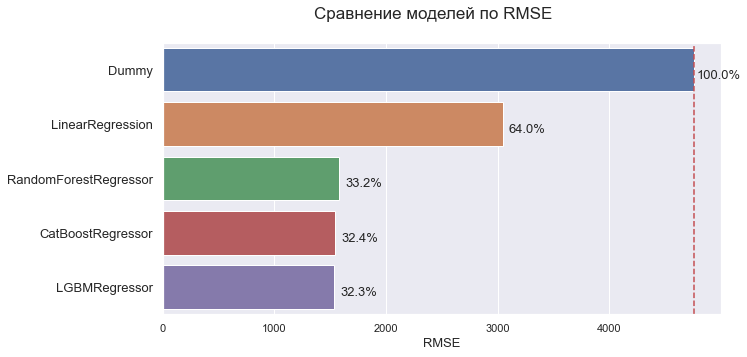

In [138]:
# сравнение метрик различных моделей по метрике RMSE с помощью функции algo_comparison()
algo_comparison(
    result_df['rmse_values'],
    result_df.index,
    'Сравнение моделей по RMSE',
    'RMSE',
    result_df.loc['Dummy', 'rmse_values']
)

Таким образом, лучшей моделью по метрике *RMSE* стала модель на основе градиентного бустинга LGBMRegressor. Определим для неё значение метрики на тестовой выборке.

In [139]:
# получение результатов работы лучшей модели на основе LGBMRegressor на тестовой выборке
rmse_score_lg = print_scores_on_test(
    grid_search, params, x_test, y_test.values.ravel(), 'градиентного бустинга LightGBM'
)

---------------------------------------------------------------------------
| Параметры модели:                                           |           |
|	model__max_depth                                      |        13 |
|	model__n_estimators                                   |      1500 |
---------------------------------------------------------------------------
| RMSE на тестовых данных для градиентного бустинга LightGBM: |   1525.22 |
---------------------------------------------------------------------------


> * Линейная регрессия позволила на этапе обучения и подбора гиперпараметров получить значение метрики равное `≈3044`, случайный лес `≈1582`, модель градиентного бустинга на основе *CatBoostRegressor* `≈1543`, на основе *LGBMRegressor* `≈1535`. Все из перечисленных моделей значительно превзошли предсказание лучшей dummy-модели (`4763`), при этом качество моделей градиентного бустинга и случайного леса почти в 2 раза лучше линейной регрессии.
> 
> * По результатам метрики *RMSE* на этапе обучения и подбора гиперпараметров лучшей моделью стал градиентный бустинг на основе *LGBMRegressor*. Проведённая проверка на тестовых данных обеспечила для модели на его основе значение метрики *RMSE* `≈1525`.
> 
> * Так как обучающая выборка содержит достаточно большое количество объектов (около 250 тыс.), обучение модели градиентного бустинга на основе *CatBoostRegressor* с перебором 2 гиперпараметров с 2 значениями в каждом на кросс-валидации занимает около 1.0 часа на графическом чипсете NVIDIA. На центральном процессоре время обучения возрастёт ещё в несколько раз. *LGBMRegressor* на CPU обучается гораздо быстрее, чем *CatBoostRegressor* на GPU.
> * Приведённое в выводах время обучения получено на локальной машине.

### Выводы по обучению моделей

> * Для обучения моделей из данных выделены группы категориальных и количественных признаков, а также целевая переменная.
> * Из предобработанного датасета созданы обучающая и тестовая выборки, разделённые в соотношении 3:1. После этого произведено разделение полученных выборок на содержащие обучающие признаки и на отдельные с целевым признаком.
> * Создана функция расчёта оптимизируемой метрики *RMSE* и на ёё основе мера, используемая при кросс-валидации.
> * В качестве базового значения ошибки при сравнении моделей использовано наименьшее из найденных значений для dummy-моделей, равное `≈4763` евро.
> * С помощью линейной регрессии удалось достичь значения метрики *RMSE* `≈3044`, что в 1.5 раза лучше, чем аналогичная метрика dummy-модели.
> * Модель случайного леса позволила получить значения метрики *RMSE* `≈1582`, что практически в 2.0 раза лучше показателя модели линейной регрессии.
> * Модель градиентного бустинга на основе *CatBoostRegressor* из библиотеки CatBoost позволила получить значение метрики *RMSE* на обучающих данных `≈1543`, что лучше рассмотренных ранее моделей.
> * Модель градиентного бустинга на основе *LGBMRegressor* позволила ещё улучшить значение метрики *RMSE* на обучающих данных, достигнув значения `≈1535`, обеспечив самое лучшее значение метрики из всех рассмотренных. К достоинствам этой модели можно также отнести быстрое обучение.
> * Таким образом, по результатам метрики *RMSE* на этапе обучения и подбора гиперпараметров лучшей моделью стал градиентный бустинг на основе *LGBMRegressor*. Проведённая проверка на тестовых данных обеспечила для модели на его основе значение метрики *RMSE* `≈1525`.
> * Проведён сравнительный анализ моделей, который показал, что все из обученных моделей превзошли предсказание лучшей dummy-модели. Линейная регрессия при этом обеспечила результат по метрике *RMSE* на `36.0%` меньший по сравнению с dummy-моделью, случайный лес на `66.8%`, а градиентные бустинги на `67.6%` и `67.7%` соотвественно.
> * При этом стоит отметить, что при незначительном по сравнению со случайным лесом приростом оптимизируемой метрики *RMSE*, для градиентного бустинга на исследуемом объёме данных значительно выросло время выполнения вычислений. Обучение модели градиентного бустинга на основе *CatBoostRegressor* с перебором 2 гиперпараметров с 2 значениями в каждом на кросс-валидации заняло около 1.0 часа на графическом процессоре. Гораздо лучше по скорости обучения градиентный бустинг на основе *LightGBM*.

## Общие выводы

> 1. Полученные в файлe `autos.csv` данные c объявлениями о продаже автомобилей были успешно загружены и проанализированы:
>    * в полученных данных содержалось около `350` тыс. записей;
>    * данные соотвествуют предоставленному описанию, содержат незначительное количество дубликатов и многочисленные пропуски в различных признаках;
>    * названия признаков (столбцов) приведены к стилю `snake_case`;
>    * из данных удалены признаки, не влияющие на стоимость, такие как количество изображений, почтовый код и время последней активности пользователя;
>    * проведена оценка каждого признака с целью выявления пропусков/аномалий в данных, которые требуют заполнения или замены;
>    * по результатам оценки признаков, относящихся к самим объявлениям (дата создания, дата выгрузки), исключены аномалии - объявления с большим периодом экспозиции, которые вероятно содержат недостоверные ценовые характеристики;
>    * также исключены аномальные значения года регистрации автомобилей, а также значения-выбросы, не дающие представления о текущем состоянии рынка автомобилей;
>    * по результатам оценки числовых и категориальных признаков также устранены отдельные аномалии и выполнены замены пропусков значений;
>    * после преобработки данных в таблице осталось `320256` объекта из начальных `354365` и `11` атрибутов из начальных `16`;
>    * из оставшихся `11` атрибутов `6` однозначно относятся к категориальным, `3` (включая целевой признак цену `price`) к количественным и `2` из-за дискретности значений и ограниченного их количества могут быть отнесены как к количественным, так и к категориальным.
>
>
> 2. Выполнено обучение моделей, определяющих рыночную стоимость автомобиля по его параметрам, и проведён их сравнительный анализ:
>    * выделены группы категориальных и количественных признаков, а также целевая переменная;
>    * созданы обучающая и тестовая выборки, разделённые в соотношении 3:1 и произведено разделение полученных выборок на содержащие обучающие признаки и на целевые признаки;
>    * создана функция расчёта оптимизируемой метрики *RMSE* и на ёё основе мера, используемая при кросс-валидации;
>    * в качестве базового значения ошибки при сравнении моделей использовано наименьшее из найденных значений для dummy-моделей, равное `≈4763` евро;
>    * проведено обучение 4 различных типов моделей;
>        * линейная регрессия
>        * случайный лес
>        * градиентный бустинг на основе *CatBoostRegressor*
>        * градиентный бустинг на основе *LGBMRegressor*
>    * модель на основе линейной регрессий позволила получить значение метрики *RMSE* `≈3044`, модель на основе случайного леса `≈1582`, модель градиентного бустинга на основе *CatBoostRegressor* позволила получить значение метрики *RMSE* на обучающих данных `≈1543` и модель на основе *LGBMRegressor* обеспечила значение метрики *RMSE* `≈1535`;
>    * лучшей моделью признана модель на основе *LGBMRegressor* и для неё получено значение метрики *RMSE* на тестовых данных, которое составило `≈1525`, что практически в два раза лучше, выдвинутого с задании условия `<2500`;
>    * сравнительный анализ моделей показал, что все из обученных моделей превзошли предсказание лучшей dummy-модели в различной степени: линейная регрессия обеспечила результат по метрике *RMSE* на `36.0%` меньший по сравнению с dummy-моделью, случайный лес на `66.8%`, а обе модели градиентного бустинга на `67.6%` и `67.7%` соотвественно;
>    * незначительный по сравнению со случайным лесом прирост оптимизируемой метрики *RMSE* для градиентного бустинга на исследуемом объёме данных достигнут за счёт значительного увеличения времени вычислений - более чем на один порядок, при условии выполнения вычислений на графическом ускорителе. Гораздо лучше по скорости обучения градиентный бустинг на основе *LightGBM*.